# Experiments for asynchronous gate and expert training with different datasets

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('device', device)
else:
    device = torch.device("cpu")
    print('device', device)

device cpu


In [5]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best guarantee of interpretable task decompositions
from moe_models.moe_expectation_model import moe_expectation_model
from helper.moe_models import cross_entropy_loss
from helper.visualise_results import imshow

device cpu
device cpu
device cpu


### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

## Load MNIST dataset

In [6]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures/test'
model_path = '../models/test'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [7]:
import torchvision.transforms as transforms

# transforms: Convert PIL image to tensors and normalize
mnist_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))]) 

In [8]:
trainsize = 10000
testsize = 2000

In [9]:
# Load and split data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=mnist_transform,
    target_transform = torch.tensor,                                 
    )
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=mnist_transform,
    target_transform = torch.tensor,)

batch_size = 64
# dataloaders
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(testsize)),
                                         batch_size=testsize,
                                         shuffle=False)
num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))


Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


Data samples


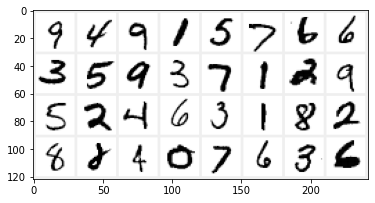

In [10]:
# create grid of images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


### Create combined rotated and unrotated MNIST image dataset of the digits 1-5

In [11]:
from PIL import Image
def rotate_dataset(d, rotation):
    result = torch.FloatTensor(d.size(0), 1, 28,28)
    tensor = transforms.ToTensor()
    norm = transforms.Normalize((0.1307,), (0.3081,)) 
    
    for i in range(d.size(0)):
        img = Image.fromarray(d[i].numpy(), mode='L')
        result[i] = norm(TF.rotate(tensor(img), rotation))
    return result

In [12]:
rot = 90

rot_train = rotate_dataset(trainset.data, rot)
rot_test= rotate_dataset(testset.data, rot)

In [13]:
# Function to extract subset of classes from the datasets
def filter_classes(classes_sub, classes_full, size, targets):
    print(classes_sub)
    start = 0
    labels = targets
    index = []
    per_class_size = ceil(size/len(classes_sub))
    for t in classes_sub:
        i = classes_full.index(t)
        index += list(np.where(labels == i)[0])[0:per_class_size]
    return index[0:size]

In [14]:
classes_mnist = ['0','1','2','3','4','5','6','7','8','9']

In [15]:
mnist_indices_train = filter_classes(classes_mnist[0:5], classes_mnist, int(trainsize/2), trainset.targets)
mnist_indices_test = filter_classes(classes_mnist[0:5], classes_mnist, int(testsize/2), testset.targets)

['0', '1', '2', '3', '4']
['0', '1', '2', '3', '4']


In [16]:
# shifting the labels by 5 to avoid overlap when selecting digits 1-5
classes_rot_mnist = ['5','6','7','8','9','10','11','12','13','14']

In [17]:
rot_trainset = TensorDataset(rot_train, trainset.targets+5)
rot_testset = TensorDataset(rot_test, testset.targets+5)

In [18]:
rot_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(rot_trainset,mnist_indices_train), batch_size=batch_size,
                                          shuffle=True, num_workers=1, pin_memory=True)
rot_testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(rot_trainset,mnist_indices_test), batch_size=len(mnist_indices_test),
                                         shuffle=True, num_workers=1, pin_memory=True)

Data samples


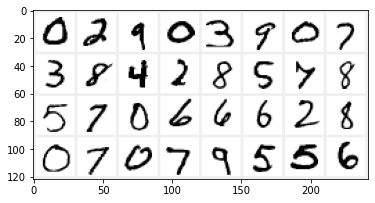

In [19]:
# create grid of images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


### Create combined rotated and unrotated MNIST image dataset of the digits 1-5

In [20]:
from PIL import Image
def rotate_dataset(d, rotation):
    result = torch.FloatTensor(d.size(0), 1, 28,28)
    tensor = transforms.ToTensor()
    norm = transforms.Normalize((0.1307,), (0.3081,)) 
    
    for i in range(d.size(0)):
        img = Image.fromarray(d[i].numpy(), mode='L')
        result[i] = norm(TF.rotate(tensor(img), rotation))
    return result

In [21]:
rot = 90

rot_train = rotate_dataset(trainset.data, rot)
rot_test= rotate_dataset(testset.data, rot)

In [22]:
# Function to extract subset of classes from the datasets
def filter_classes(classes_sub, classes_full, size, targets):
    print(classes_sub)
    start = 0
    labels = targets
    index = []
    per_class_size = ceil(size/len(classes_sub))
    for t in classes_sub:
        i = classes_full.index(t)
        index += list(np.where(labels == i)[0])[0:per_class_size]
    return index[0:size]

In [23]:
classes_mnist = ['0','1','2','3','4','5','6','7','8','9']

In [24]:
mnist_indices_train = filter_classes(classes_mnist[0:5], classes_mnist, int(trainsize/2), trainset.targets)
mnist_indices_test = filter_classes(classes_mnist[0:5], classes_mnist, int(testsize/2), testset.targets)

['0', '1', '2', '3', '4']
['0', '1', '2', '3', '4']


In [25]:
# shifting the labels by 5 to avoid overlap when selecting digits 1-5
classes_rot_mnist = ['5','6','7','8','9','10','11','12','13','14']

In [26]:
rot_trainset = TensorDataset(rot_train, trainset.targets+5)
rot_testset = TensorDataset(rot_test, testset.targets+5)

In [27]:
rot_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(rot_trainset,mnist_indices_train), batch_size=batch_size,
                                          shuffle=True, num_workers=1, pin_memory=True)
rot_testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(rot_trainset,mnist_indices_test), batch_size=len(mnist_indices_test),
                                         shuffle=True, num_workers=1, pin_memory=True)

Data samples


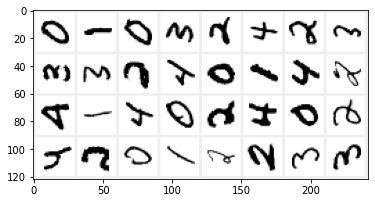

In [28]:
# create grid of images
dataiter = iter(rot_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


In [29]:
rot_unrot_trainset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(trainset,mnist_indices_train), 
                                                 torch.utils.data.Subset(rot_trainset,mnist_indices_train)])
rot_unrot_testset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(testset,mnist_indices_test),
                                                torch.utils.data.Subset(rot_testset,mnist_indices_test)])

In [30]:
rot_unrot_trainloader = torch.utils.data.DataLoader(rot_unrot_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1, pin_memory=True)
rot_unrot_testloader = torch.utils.data.DataLoader(rot_unrot_testset, batch_size=len(rot_unrot_testset),
                                         shuffle=True, num_workers=1, pin_memory=True)

Data samples


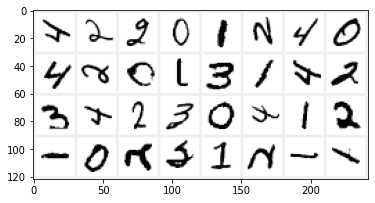

In [31]:
# create grid of images
dataiter = iter(rot_unrot_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


## Create combined FMNIST and MNIST dataset

In [32]:
# transforms: Convert PIL image to tensors and normalize
fmnist_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.2859,), (0.3530,))]) 

In [33]:
fmnist_trainset = torchvision.datasets.FashionMNIST('data', transform=fmnist_transform, train=True, download=True)

In [34]:
fmnist_testset = torchvision.datasets.FashionMNIST('data',transform=fmnist_transform, train=False)

In [35]:
# Since we are combining the fashion mnist and mnist data that have the same numerical labels from 0-9 
# we want to offset the mnist target so there is no overlap of the labels
def target_transform(target):
    return target+2

In [36]:
mnist_trainset = torchvision.datasets.MNIST('data', transform=mnist_transform, target_transform=target_transform, train=True, download=True)

In [37]:
mnist_testset = torchvision.datasets.MNIST('data',transform=mnist_transform, target_transform=target_transform, train=False)

In [38]:
classes_fmnist = ['t-shirt', 'Trouser', 'Pullover','Dress','Coat','Sandal',
                  'Shirt','Sneaker','Bag','Ankle boot']
classes_mnist = ['0','1','2','3','4','5','6','7','8','9']

# Combined fmnist and mnist classes. 
classes_fmnist_mnist = classes_fmnist[0:6]+[str(n) for n in range(4,10)]
print('classes_fmnist_mnist', classes_fmnist_mnist)

classes_fmnist_mnist ['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', '4', '5', '6', '7', '8', '9']


In [39]:
# Function to extract subset of classes from the datasets
def filter_classes(classes_sub, classes_full, size, data):
    print(classes_sub)
    start = 0
    labels = data.targets
    index = []
    per_class_size = ceil(size/len(classes_sub))
    for t in classes_sub:
        i = classes_full.index(t)
        index += list(np.where(labels == i)[0])[0:per_class_size]
    return index[0:size]

In [40]:
# Get the data for first 6 classes of fmnist dataset
fmnist_indices_train = filter_classes(classes_fmnist[0:6], classes_fmnist, int(trainsize/2), fmnist_trainset)
fmnist_indices_test = filter_classes(classes_fmnist[0:6], classes_fmnist, int(testsize/2), fmnist_testset)

['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal']
['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal']


In [41]:
fmnist_trainset.targets[fmnist_indices_train]

tensor([0, 0, 0,  ..., 5, 5, 5])

In [42]:
# Get the data for last 6 classes of fmnist dataset
mnist_indices_train = filter_classes(classes_mnist[4:], classes_mnist, int(trainsize/2), mnist_trainset)
mnist_indices_test = filter_classes(classes_mnist[4:], classes_mnist, int(testsize/2), mnist_testset)

['4', '5', '6', '7', '8', '9']
['4', '5', '6', '7', '8', '9']


In [43]:
# Create the combined dataset with fmnist and mnist classes
fmnist_mnist_trainset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(fmnist_trainset,fmnist_indices_train), 
                         torch.utils.data.Subset(mnist_trainset,mnist_indices_train)])
fmnist_mnist_testset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(fmnist_testset,fmnist_indices_test), 
                        torch.utils.data.Subset(mnist_testset,mnist_indices_test)])
train_size = len(fmnist_indices_train)+len(mnist_indices_train)
test_size = len(fmnist_indices_test)+len(mnist_indices_test)
print("Train size", train_size)
print("Test size", test_size)

Train size 10000
Test size 2000


In [44]:
fmnist_mnist_trainloader = torch.utils.data.DataLoader(fmnist_mnist_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1, pin_memory=True)
fmnist_mnist_testloader = torch.utils.data.DataLoader(fmnist_mnist_testset, batch_size=len(fmnist_mnist_testset),
                                         shuffle=True, num_workers=1, pin_memory=True)

In [45]:
num_classes_fmnist_mnist = len(classes_fmnist_mnist)

In [ ]:
# create grid of images
dataiter = iter(fmnist_mnist_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32].view(-1, 1, 28, 28).type(torch.float))

print('Data samples')
# show images
imshow(img_grid, one_channel=True)

## Create imbalanced MNIST trainset

In [47]:
def imbalance_dataset(labels, fracs, selected_labels, size):
    
    unique_labels = torch.unique(labels)
    per_class_size = ceil(size/len(unique_labels))
    all_indices = []
    for l in unique_labels:
        indices = torch.where(labels == l)[0][0:per_class_size]
        if l in selected_labels:
            frac = fracs[np.random.randint(0,len(fracs),1)[0]]
        else:
            frac = 1.0
        selected_indices = list(np.random.choice(indices, int(frac*len(indices))))
        all_indices = all_indices + selected_indices
    return all_indices



In [48]:
# fracs = [0.25,0.5,0.75, 1.0]
# fracs = [0.3]

# imbalanced_indices = imbalance_dataset(trainset.targets, fracs, [0,1,2,3,4,6,7,8,9], trainsize*3) 

# imbalanced_trainset = torch.utils.data.Subset(trainset,imbalanced_indices)

# torch.save(imbalanced_trainset, open('data/imbalanced_dataset_5.data', 'wb'))

In [49]:
imbalanced_trainset = torch.load(open('data/imbalanced_dataset_5.data', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'data/imbalanced_dataset_5.data'

In [50]:
imbalanced_trainloader_all = torch.utils.data.DataLoader(imbalanced_trainset, 
                                                         batch_size=len(imbalanced_trainset),
                                                         shuffle=True, num_workers=1, pin_memory=True)
for _, labels in imbalanced_trainloader_all:
    plt.hist(labels.numpy(), align='mid')

NameError: name 'imbalanced_trainset' is not defined

In [51]:
imbalanced_trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=64,
                                          shuffle=True, num_workers=1, pin_memory=True)

NameError: name 'imbalanced_trainset' is not defined

In [52]:
# create grid of images
dataiter = iter(imbalanced_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32].view(-1, 1, 28, 28).type(torch.float))

print('Data samples')
# show images
imshow(img_grid, one_channel=True)

NameError: name 'imbalanced_trainloader' is not defined

## Define expert and gate networks

In [53]:
# # Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
# class expert_layers(nn.Module):
#     def __init__(self, num_classes):
#         super(expert_layers, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
#         self.fc1 = nn.Linear(in_features=1*13*13, out_features=64) # this is a pure linear transform
#         self.fc2 = nn.Linear(in_features=64, out_features=32) # this is a pure linear transform
        
#         self.out = nn.Linear(in_features=32, out_features=num_classes)
                
#     def forward(self, t):
#         # conv 1
#         t = self.conv1(t)
        
#         t = F.relu(t)
#         t = F.max_pool2d(t, kernel_size=2, stride=2)
        
#         # fc1
#         t = t.reshape(-1, 1*13*13)
#         t = self.fc1(t)
#         t = F.relu(t)

#         # fc2
#         t = self.fc2(t)
                      
#         self.hidden = t
            
#         t = F.relu(t)
                
#         # output
#         t = F.softmax(self.out(t), dim=1)
        
#         return t

In [54]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes):
        super(expert_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=10) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=10, out_features=num_classes)
        
        self.num_classes = num_classes
        
    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        
        self.hidden = t
        
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
                
        return t

In [ ]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_encoder(nn.Module):
    def __init__(self):
        super(gate_encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)
        self.fc1 = nn.Linear(in_features=1*12*12, out_features=64) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=64, out_features=10) # this is a pure linear transform
        
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*12*12)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        
        return t

In [ ]:
# # Convolutional network with one convolutional layer and 2 hidden layers with ReLU activation
# class gate_layers(nn.Module):
#     def __init__(self, gate_encoder, num_experts, context):
#         super(gate_layers, self).__init__()
#         # define layers
#         # linear layers to process input+context
# #         self.fc1 = nn.Linear(in_features=context+32, out_features=64)
#         self.fc1 = nn.Linear(in_features=context+32, out_features=64)
#         self.fc2 = nn.Linear(in_features=64, out_features=32)
        
#         self.out = nn.Linear(in_features=32, out_features=num_experts)
# #         self.gate_encoder = gate_encoder

#     def forward(self, t, T=1.0, v=None):
        
# #         t = self.gate_encoder(t)
        
# #         t = torch.hstack([t, v])
        
#         t = self.fc1(t)
#         t = F.relu(t)

#         # fc2
#         t = self.fc2(t)
        
# #         t = F.relu(t)
    
#         # output
# #         t = self.out(t)
# #         t = F.softmax(t/T, dim=1)
        
#         return t


In [ ]:
# # Convolutional network with one convolutional layer and 2 hidden layers with ReLU activation
# class gate_layers(nn.Module):
#     def __init__(self, num_experts):
#         super(gate_layers, self).__init__()
#         # define layers
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)

#         self.fc1 = nn.Linear(in_features=1*13*13, out_features=64)
#         self.fc2 = nn.Linear(in_features=64, out_features=32)
        
#         self.out = nn.Linear(in_features=32, out_features=num_experts)
        
#     def forward(self, t, T=1.0, y=None):
#         # conv 1
#         t = self.conv1(t)
#         t = F.relu(t)
#         t = F.max_pool2d(t, kernel_size=2, stride=2)
#         # fc1
#         t = t.reshape(-1, 1*12*12)
            
#         t = self.fc1(t)
#         t = F.relu(t)

#         # fc2
#         t = self.fc2(t)
# #         t = F.relu(t)

# #         # output
# #         t = self.out(t)
# #         t = F.softmax(t/T, dim=1)
#         return t


In [55]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)

        self.fc1 = nn.Linear(in_features=1*13*13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self.out = nn.Linear(in_features=10, out_features=num_experts)
        self.num_experts = num_experts

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        
        return t


In [56]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes))
    return nn.ModuleList(models)

In [ ]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class single_model(nn.Module):
    def __init__(self, num_classes=10):
        super(single_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=64) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=64, out_features=32) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=32, out_features=num_classes)
        
        self.num_classes = num_classes
        
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
        
        return t

## Initialize configurations and helper functions

In [57]:
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

In [58]:
# gate covariant shift regularization flag 
w_importance = 0.0 
w_ortho = 0.0

def generate_plot_file(dataset, temp=1.0, w_importance=0.0, w_ortho=0.0, w_sample_sim=0.0, w_exp_gamma=0.0, specific=''):
    plot_file = dataset
    if w_importance > 0:
        plot_file += '_importance_'+'{:.1f}'.format(w_importance)
    if not temp == 1.0:
        plot_file += '_temp_'+'{:.1f}'.format(temp)
    if w_ortho > 0:
        plot_file += '_ortho_'+'{:.1f}'.format(w_ortho)
    if w_sample_sim > 0:
        if w_exp_gamma < 1:
            plot_file += '_sample_sim_'+str(w_sample_sim)
        else:
            plot_file += '_sample_sim_'+'{:.1f}'.format(w_sample_sim)        
    if w_exp_gamma > 0:
        plot_file += '_exp_gamma_'+'{:.3f}'.format(w_exp_gamma).strip('0')
    plot_file += '_'+specific
    
    return plot_file

## Funtion to train MoR in: 
### (1) dual temp mode where experts and gates are trained with different temperatures
### (2) with regularization
### (3) dual temp and regularization
### (4) without regularization when w_importance = 0.
### (5) training the whole model end-to-end when T = 0.

### NOTE: when importance is set to 0 then it is the default training without regularization

In [59]:
from itertools import product

def train_with_attention(model_1, trainloader, testloader, runs, temps, w_importance_range=[0], 
                         w_ortho_range=[0], num_classes=10, total_experts=5, num_epochs=20):
    
    hidden = 10
    
    for T, w_importance, w_ortho in product(temps, w_importance_range, w_ortho_range):
        
        print('Temperature',['{:.1f}'.format(t) for t in T])
        print('w_importance','{:.1f}'.format(w_importance))
        print('w_ortho','{:.1f}'.format(w_ortho))

        n_run_models_1 = []
        for run in range(runs):

            print('Run:', run), 

            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,
                                               'experts':{}},}
            for key, val in models.items():

                expert_models = experts(total_experts, num_classes).to(device)
                
                gate_model = gate_layers(total_experts).to(device)

                moe_model = val['model'](total_experts, num_classes, attention_flag=1, hidden=hidden, 
                                         experts=expert_models, gate=gate_model).to(device)

                optimizer_experts = optim.Adam(expert_models.parameters(), lr=0.001, amsgrad=False)

                optimizer_gate = optim.Adam(gate_model.parameters(), lr=0.001, amsgrad=False)
                
                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
                

                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                       optimizer_experts = optimizer_experts, optimizer_gate=optimizer_gate, 
                                       T = T, w_importance=w_importance, 
                                       accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}

            n_run_models_1.append(models)

        # Save all the trained models
        
        plot_file = generate_plot_file(model_1, T[0], w_importance=w_importance, w_ortho=w_ortho, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')
        print(plot_file)
        torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))


In [ ]:
from numpy import array
from numpy import random
from numpy import dot
from scipy.special import softmax
 
# encoder representations of four different words
word_1 = array([1, 0, 0])
word_2 = array([0, 1, 0])
word_3 = array([1, 1, 0])
word_4 = array([0, 0, 1])
 
# stacking the word embeddings into a single array
words = array([word_1, word_2, word_3, word_4])
 
# generating the weight matrices
random.seed(42)
W_Q = random.randint(3, size=(3, 3))
W_K = random.randint(3, size=(3, 3))
W_V = random.randint(3, size=(3, 3))
 
# generating the queries, keys and values
Q = words @ W_Q
K = words @ W_K
V = words @ W_V
 
# scoring the query vectors against all key vectors
scores = Q @ K.transpose()
 
# computing the weights by a softmax operation
weights = softmax(scores / K.shape[1] ** 0.5, axis=1)
print(weights.shape, V.shape)
 
# computing the attention by a weighted sum of the value vectors
attention = weights @ V
 
print(attention)

## Experiment 1: MoE model training with attention

### MNIST data

In [65]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_with_attention'

In [66]:
total_experts = 5

In [67]:
num_epochs = 20

In [68]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [69]:
runs = 10

In [70]:
train_with_attention(model_1, trainloader, testloader, runs, temps, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
Run: 0
epoch 0 training loss 1.57 , training accuracy 0.51 , test accuracy 0.62
epoch 1 training loss 0.70 , training accuracy 0.78 , test accuracy 0.81
epoch 2 training loss 0.44 , training accuracy 0.88 , test accuracy 0.86
epoch 3 training loss 0.33 , training accuracy 0.91 , test accuracy 0.89
epoch 4 training loss 0.28 , training accuracy 0.92 , test accuracy 0.89
epoch 5 training loss 0.25 , training accuracy 0.93 , test accuracy 0.89
epoch 6 training loss 0.22 , training accuracy 0.94 , test accuracy 0.90
epoch 7 training loss 0.20 , training accuracy 0.94 , test accuracy 0.90
epoch 8 training loss 0.19 , training accuracy 0.95 , test accuracy 0.90
epoch 9 training loss 0.17 , training accuracy 0.95 , test accuracy 0.90
epoch 10 training loss 0.16 , training accuracy 0.95 , test accuracy 0.91
epoch 1

### MNIST imbalanced data

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_imbalanced_5_dual_temp'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps

In [ ]:
w_importance_range = [0.0]

In [ ]:
runs = 10

In [ ]:
train_dual_temp_regularization_model(model_1, imbalanced_trainloader, testloader, runs, temps, w_importance_range, num_classes, total_experts, num_epochs)

### Combined rotated and unrotated MNIST data

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'rot_mnist_dual_temp'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps

In [ ]:
w_importance_range = [0.0]

In [ ]:
runs = 10

In [ ]:
train_dual_temp_regularization_model(model_1, rot_unrot_trainloader, rot_unrot_testloader, runs, temps, w_importance_range, num_classes, total_experts, num_epochs)

### Combined FMNIST MNIST data

In [71]:
# Model with gate and expert parameters initialized to default values
model_1 = 'fmnist_mnist_with_attention'

In [72]:
total_experts = 6

In [73]:
num_epochs = 20

In [74]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [75]:
runs = 10

In [76]:
train_with_attention(model_1, fmnist_mnist_trainloader, fmnist_mnist_testloader, runs, temps, num_classes=num_classes_fmnist_mnist, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 0.0
Run: 0
epoch 0 training loss 1.76 , training accuracy 0.39 , test accuracy 0.60
epoch 1 training loss 0.82 , training accuracy 0.69 , test accuracy 0.71
epoch 2 training loss 0.62 , training accuracy 0.75 , test accuracy 0.74
epoch 3 training loss 0.53 , training accuracy 0.81 , test accuracy 0.80
epoch 4 training loss 0.45 , training accuracy 0.85 , test accuracy 0.83
epoch 5 training loss 0.38 , training accuracy 0.88 , test accuracy 0.84
epoch 6 training loss 0.34 , training accuracy 0.89 , test accuracy 0.85
epoch 7 training loss 0.31 , training accuracy 0.89 , test accuracy 0.86
epoch 8 training loss 0.30 , training accuracy 0.90 , test accuracy 0.87
epoch 9 training loss 0.28 , training accuracy 0.90 , test accuracy 0.87
epoch 10 training loss 0.28 , training accuracy 0.91 , test accuracy 0.87
epoch 1

## Experiment 2: MoE model training with attention and gate regularization

### MNIST data

In [77]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_with_attn_reg'

In [78]:
total_experts = 5

In [79]:
num_epochs = 20

In [80]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [81]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [78]:
runs = 10

In [82]:
train_with_attention(model_2, trainloader, testloader, runs, temps, w_importance_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.2
w_ortho 0.0
Run: 0
epoch 0 training loss 1.52 , training accuracy 0.56 , test accuracy 0.74
epoch 1 training loss 0.60 , training accuracy 0.87 , test accuracy 0.86
epoch 2 training loss 0.41 , training accuracy 0.91 , test accuracy 0.88
epoch 3 training loss 0.34 , training accuracy 0.93 , test accuracy 0.90
epoch 4 training loss 0.30 , training accuracy 0.94 , test accuracy 0.90
epoch 5 training loss 0.26 , training accuracy 0.95 , test accuracy 0.90
epoch 6 training loss 0.21 , training accuracy 0.95 , test accuracy 0.91
epoch 7 training loss 0.18 , training accuracy 0.96 , test accuracy 0.91
epoch 8 training loss 0.16 , training accuracy 0.96 , test accuracy 0.91
epoch 9 training loss 0.15 , training accuracy 0.97 , test accuracy 0.92
epoch 10 training loss 0.14 , training accuracy 0.97 , test accuracy 0.93
epoch 1

### MNIST imbalanced data

In [ ]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_imbalanced_5_with_regularization'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
temps = [1.0]

In [8]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range 

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [9]:
runs = 10

In [10]:
train_dual_temp_regularization_model(model_2, imbalanced_trainloader, testloader, runs, temps, w_importance_range, num_classes, total_experts, num_epochs)

NameError: name 'train_dual_temp_regularization_model' is not defined

### Combined rotated and unrotated MNIST data

In [ ]:
# Model with gate and expert parameters initialized to default values
model_2 = 'rot_mnist_with_regularization'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

In [ ]:
runs = 10

In [ ]:
train_with_regularization(model_2, rot_unrot_trainloader, rot_unrot_testloader, runs, w_importance_range, num_classes, total_experts, num_epochs)

### Combined FMNIST MNIST data

In [83]:
# Model with gate and expert parameters initialized to default values
model_2 = 'fmnist_mnist_with_attn_reg'

In [84]:
total_experts = 6

In [85]:
num_epochs = 20

In [88]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [86]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [87]:
runs = 10

In [89]:
train_with_attention(model_2, fmnist_mnist_trainloader, fmnist_mnist_testloader, runs, temps=temps, w_importance_range=w_importance_range, 
                     num_classes=num_classes_fmnist_mnist, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.2
w_ortho 0.0
Run: 0
epoch 0 training loss 1.58 , training accuracy 0.48 , test accuracy 0.74
epoch 1 training loss 0.69 , training accuracy 0.80 , test accuracy 0.80
epoch 2 training loss 0.49 , training accuracy 0.85 , test accuracy 0.84
epoch 3 training loss 0.42 , training accuracy 0.87 , test accuracy 0.85
epoch 4 training loss 0.38 , training accuracy 0.88 , test accuracy 0.86
epoch 5 training loss 0.35 , training accuracy 0.89 , test accuracy 0.87
epoch 6 training loss 0.32 , training accuracy 0.90 , test accuracy 0.88
epoch 7 training loss 0.30 , training accuracy 0.91 , test accuracy 0.88
epoch 8 training loss 0.29 , training accuracy 0.91 , test accuracy 0.88
epoch 9 training loss 0.28 , training accuracy 0.92 , test accuracy 0.88
epoch 10 training loss 0.27 , training accuracy 0.92 , test accuracy 0.88
epoch 1

## Experiment 4: MoE model training with dual temp and attention

### MNIST data

In [64]:
# Model with gate and expert parameters initialized to default values
model_4 = 'mnist_dual_temp_with_attention'

In [65]:
total_experts = 5

In [66]:
num_epochs = 20

In [68]:
temps = [[T]* num_epochs for T in np.arange(1.1,1.6,0.1)]
temps += [[T]* num_epochs for T in np.arange(2,7,2)]
np.unique(temps)

array([1.1, 1.2, 1.3, 1.4, 1.5, 2. , 4. , 6. ])

In [69]:
runs = 10

In [72]:
train_with_attention(model_4,  trainloader, testloader, runs, temps, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1']
w_importance 0.0
w_ortho 0.0
Run: 0
epoch 0 training loss 1.86 , training accuracy 0.41 , test accuracy 0.66
epoch 1 training loss 0.92 , training accuracy 0.75 , test accuracy 0.76
epoch 2 training loss 0.57 , training accuracy 0.84 , test accuracy 0.82
epoch 3 training loss 0.44 , training accuracy 0.88 , test accuracy 0.85
epoch 4 training loss 0.36 , training accuracy 0.90 , test accuracy 0.87
epoch 5 training loss 0.32 , training accuracy 0.91 , test accuracy 0.87
epoch 6 training loss 0.29 , training accuracy 0.92 , test accuracy 0.88
epoch 7 training loss 0.27 , training accuracy 0.93 , test accuracy 0.87
epoch 8 training loss 0.25 , training accuracy 0.93 , test accuracy 0.89
epoch 9 training loss 0.23 , training accuracy 0.93 , test accuracy 0.88
epoch 10 training loss 0.22 , training accuracy 0.94 , test accuracy 0.89
epoch 1

### MNIST imbalanced data

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_imbalanced_5_dual_temp_with_regularization'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
w_importance_range = [i * 0.2 for i in range(1, 6)]
temps = [1.3]
w_importance_range = [0.8, 1.0]
print(temps)
print(w_importance_range)

In [ ]:
runs = 10

In [ ]:
train_dual_temp_regularization_model(model_1, imbalanced_trainloader, testloader, runs, temps, w_importance_range, num_classes, total_experts, num_epochs)

## Experiment 5: MoE model training with dual temperature schedule

### MNIST data

In [ ]:
# Model with gate and expert parameters initialized to default values
model_5 = 'mnist_dual_temp_on_schedule'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
temps =np.asarray([[1.2]*6+[1.1]*6+[1.0]*8])
temps =np.asarray([[2.0]*5+[1.5]*5+[1.1]*5+[1.0]*5])
temps

In [ ]:
w_importance_range = [0.0]

In [ ]:
runs = 10

In [ ]:
train_dual_temp_regularization_model(model_5, trainloader, testloader, runs, temps, w_importance_range, num_classes, total_experts, num_epochs)

### MNIST imbalanced data

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_imbalanced_5_dual_temp_on_schedule'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [11]:
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps =np.asarray([[1.2]*6+[1.1]*6+[1.0]*8])
temps =np.asarray([[1.2]*6+[1.1]*6+[1.0]*8, [2.0]*5+[1.5]*5+[1.1]*5+[1.0]*5])
temps

NameError: name 'np' is not defined

In [ ]:
w_importance_range = [0.0]

In [ ]:
runs = 10

In [ ]:
train_dual_temp_regularization_model(model_1, imbalanced_trainloader, testloader, runs, temps, w_importance_range, num_classes, total_experts, num_epochs)

## Experiment 6: MoE model training with output regularization

### MNIST data

In [62]:
# Model with gate and expert parameters initialized to default values
model_6 = 'mnist_attn_output_reg'

In [63]:
total_experts = 5

In [64]:
num_epochs = 20

In [65]:
temps = [[1.0]* num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [66]:
w_importance_range = [0.0]

In [67]:
w_ortho_range = [i * 0.2 for i in range(1, 6)]
w_ortho_range = [1.0]
w_ortho_range

[1.0]

In [68]:
runs = 10

In [69]:
train_with_attention(model_6, trainloader, testloader, runs, temps, w_importance_range, w_ortho_range, num_classes, total_experts, num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_ortho 1.0
Run: 0
epoch 0 training loss 1.08 , training accuracy 0.71 , test accuracy 0.84
epoch 1 training loss 0.34 , training accuracy 0.91 , test accuracy 0.86
epoch 2 training loss 0.26 , training accuracy 0.93 , test accuracy 0.90
epoch 3 training loss 0.21 , training accuracy 0.94 , test accuracy 0.91
epoch 4 training loss 0.18 , training accuracy 0.95 , test accuracy 0.91
epoch 5 training loss 0.15 , training accuracy 0.96 , test accuracy 0.92
epoch 6 training loss 0.13 , training accuracy 0.96 , test accuracy 0.92
epoch 7 training loss 0.11 , training accuracy 0.97 , test accuracy 0.93
epoch 8 training loss 0.10 , training accuracy 0.98 , test accuracy 0.92
epoch 9 training loss 0.09 , training accuracy 0.98 , test accuracy 0.93
epoch 10 training loss 0.07 , training accuracy 0.98 , test accuracy 0.93
epoch 1

## Experiment 5: Training with single model

### MNIST data

In [73]:
model_5 = 'mnist_single_model_hidden_32'

In [74]:
num_epochs = 20

In [75]:
runs = 10

In [76]:
train_single_model(model_5, trainloader, testloader, num_classes, num_epochs, runs)

NameError: name 'train_single_model' is not defined

### Imbalanced MNIST data

In [ ]:
model_4 = 'imbalanced_mnist_single_model'

In [ ]:
num_epochs = 20

In [ ]:
runs = 10

In [ ]:
train_single_model(model_4, imbalanced_trainloader, testloader, num_classes, num_epochs, runs)

### Combined rotated and unrotated MNIST data

In [ ]:
model_4 = 'rot_mnist_single_model'

In [ ]:
num_epochs = 20

In [ ]:
runs = 10

In [ ]:
train_single_model(model_4, rot_unrot_trainloader, rot_unrot_testloader, num_classes, num_epochs, runs)

### Combined FMNIST MNIST data

In [ ]:
model_4 = 'fmnist_mnist_single_model'

In [ ]:
num_epochs = 20

In [ ]:
runs = 10

In [ ]:
train_single_model(model_4, fmnist_mnist_trainloader, fmnist_mnist_testloader, num_classes_fmnist_mnist, num_epochs, runs)

## Results

mnist_with_attn_reg_hidden_32_importance_1.0_10_5_models.pt
Model 0
20 torch.Size([20, 10000, 5])


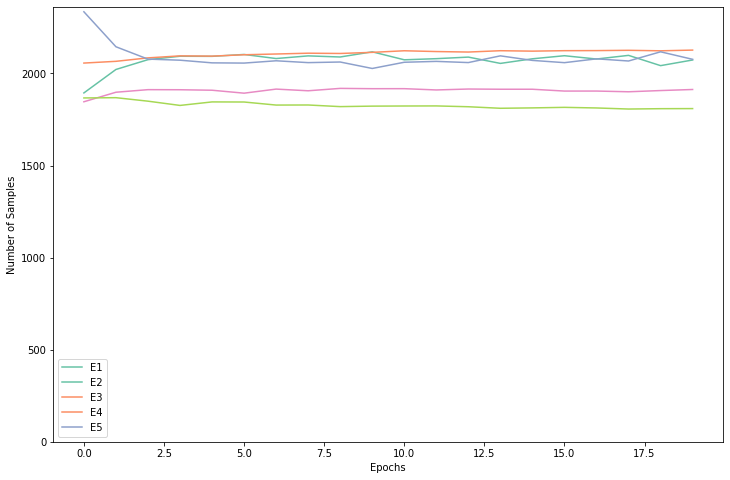

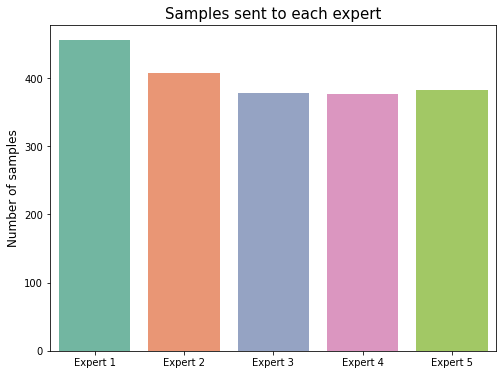

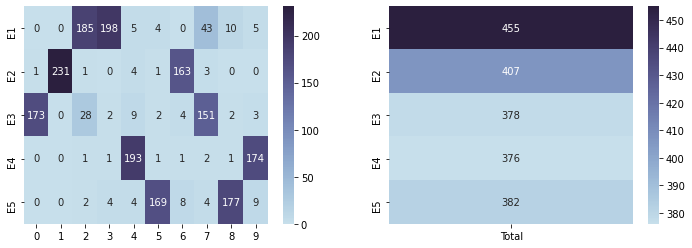


Experts used by the gate for classification of each digit


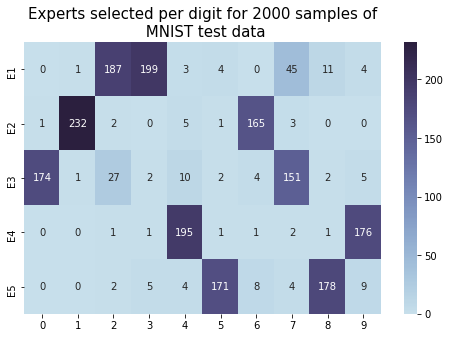

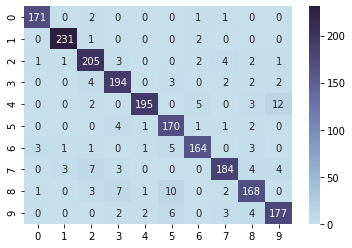

Model 1
20 torch.Size([20, 10000, 5])


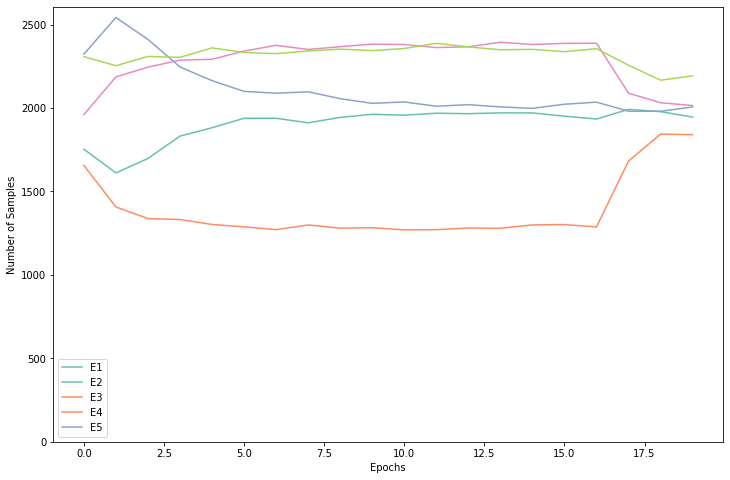

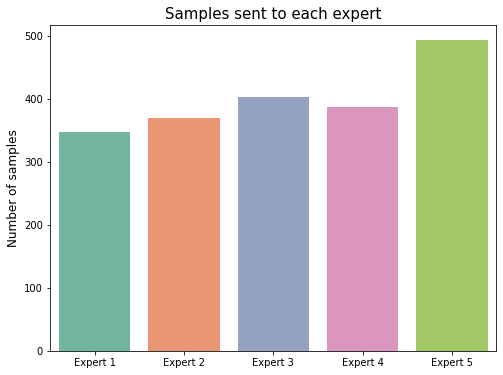

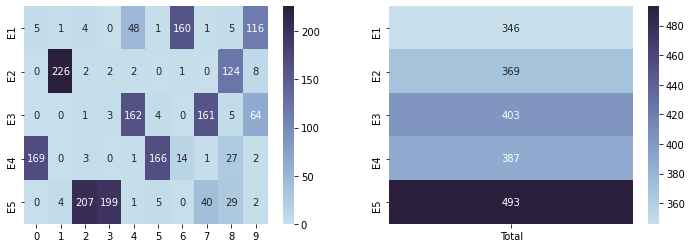


Experts used by the gate for classification of each digit


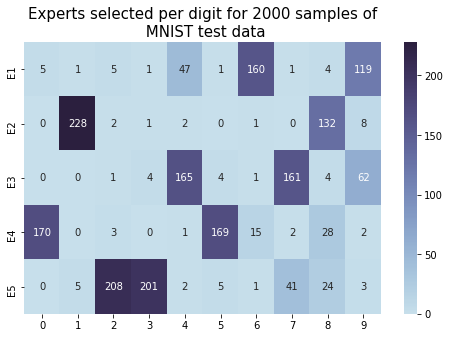

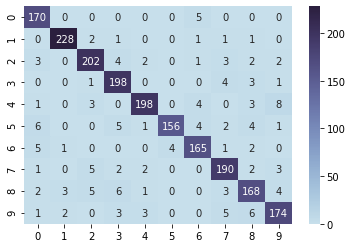

Model 2
20 torch.Size([20, 10000, 5])


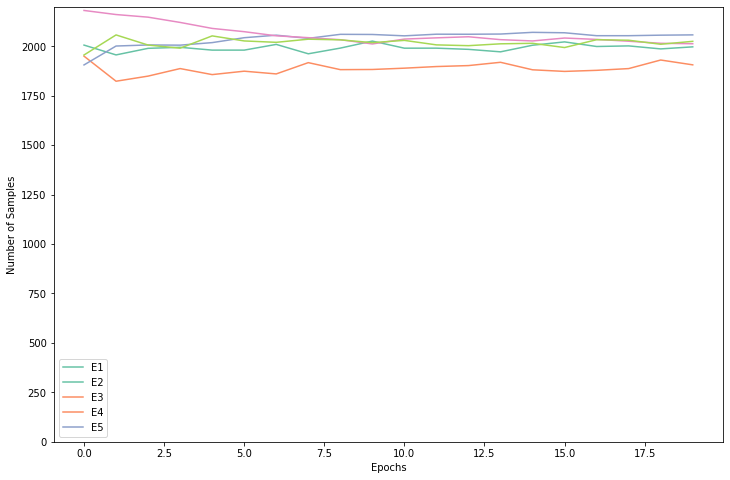

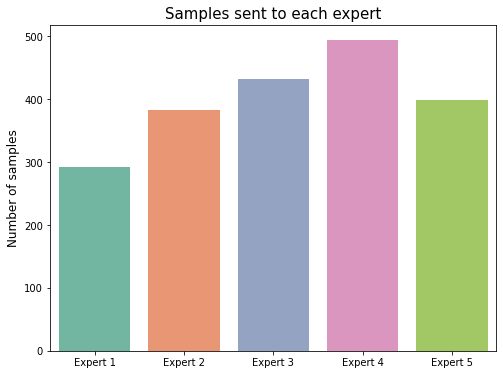

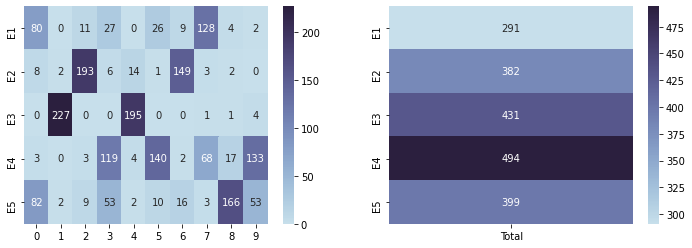


Experts used by the gate for classification of each digit


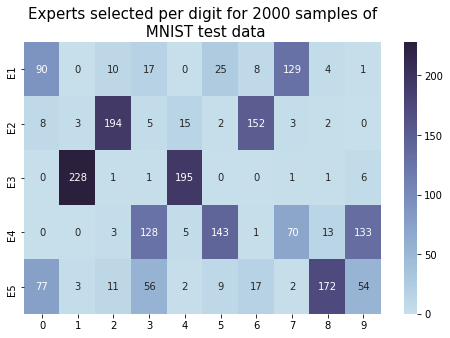

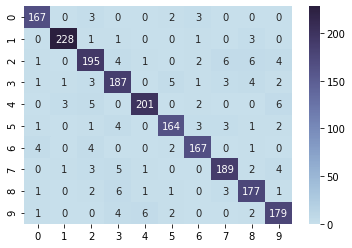

Model 3
20 torch.Size([20, 10000, 5])


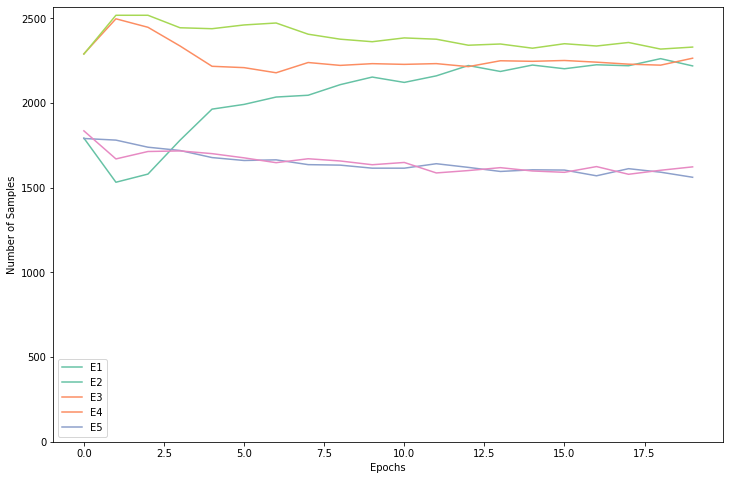

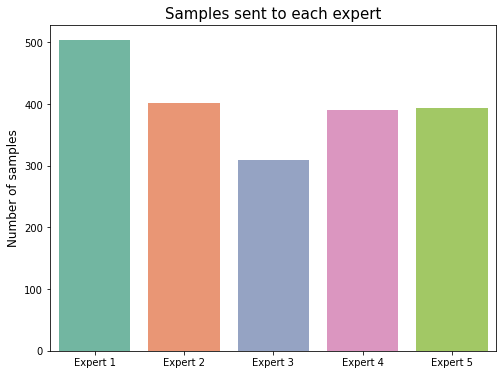

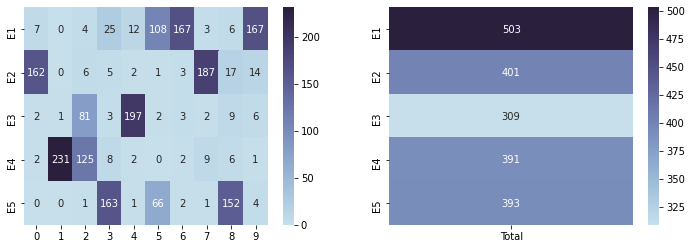


Experts used by the gate for classification of each digit


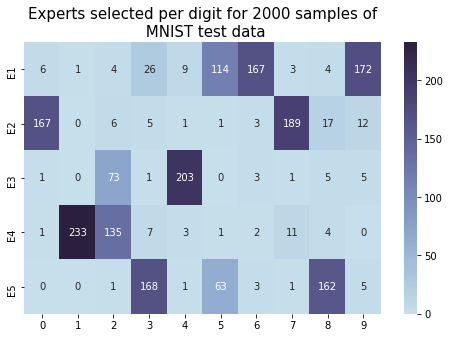

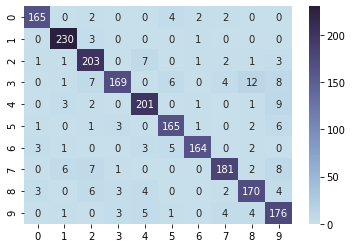

Model 4
20 torch.Size([20, 10000, 5])


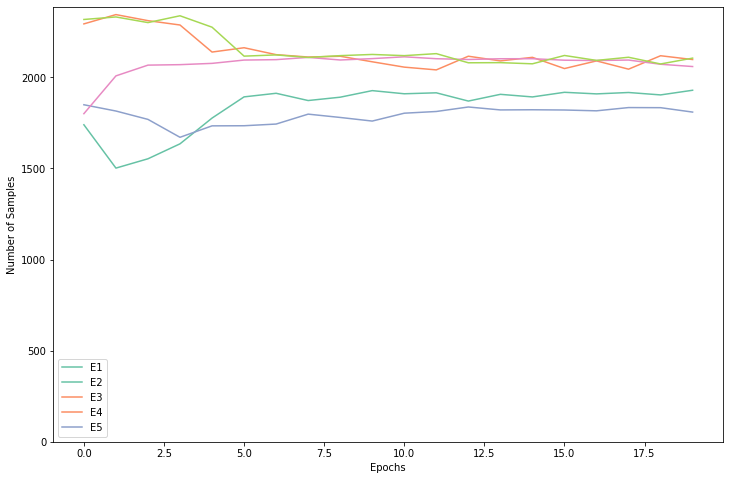

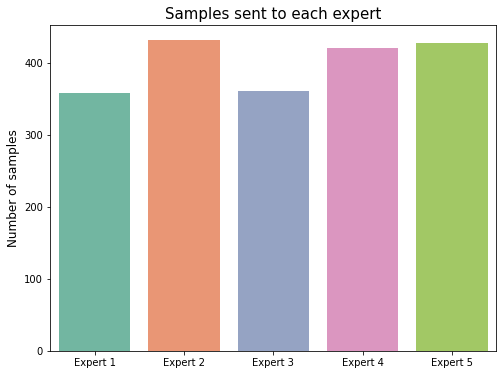

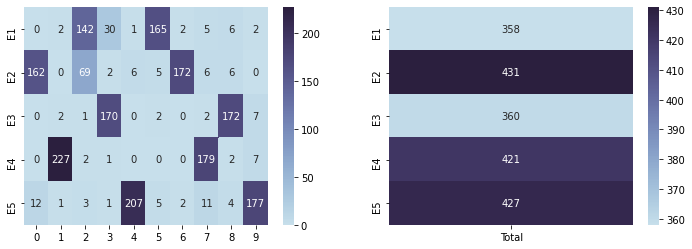


Experts used by the gate for classification of each digit


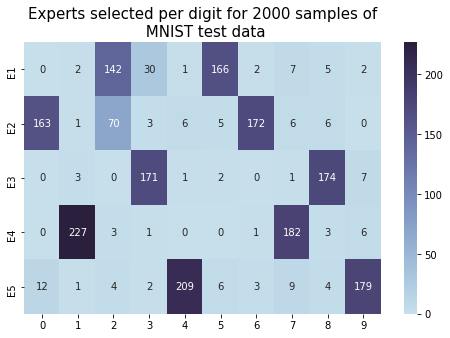

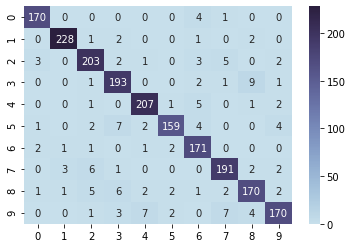

Model 5
20 torch.Size([20, 10000, 5])


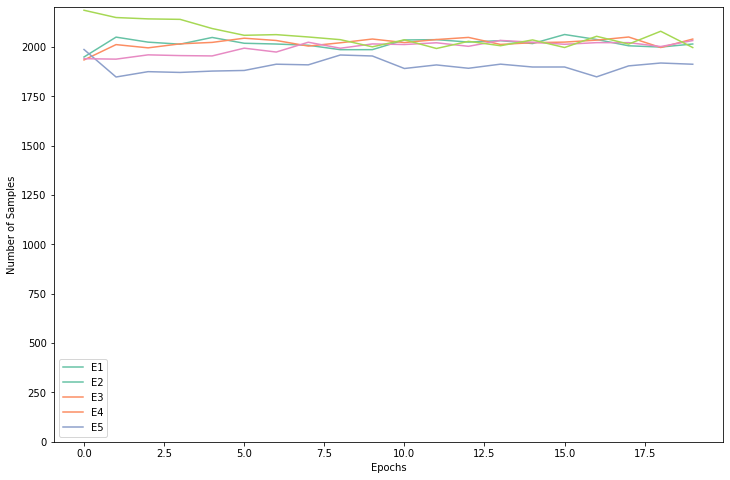

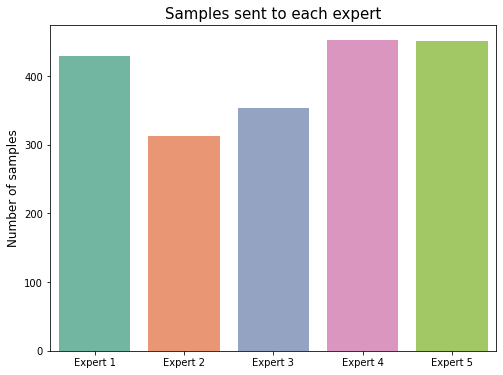

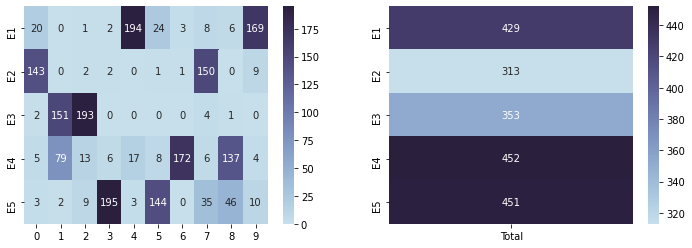


Experts used by the gate for classification of each digit


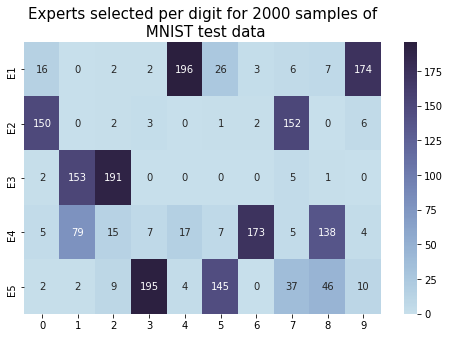

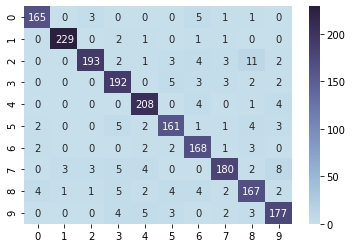

Model 6
20 torch.Size([20, 10000, 5])


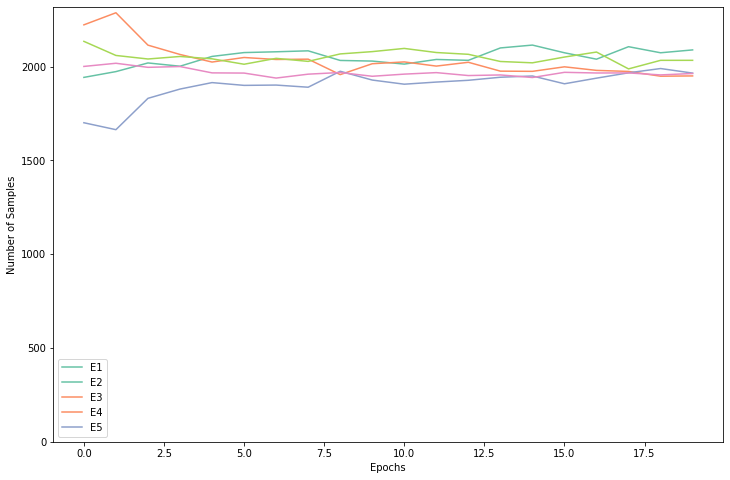

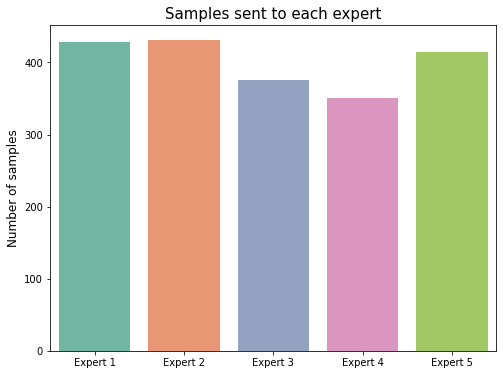

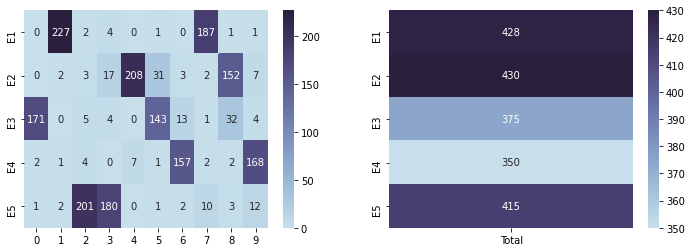


Experts used by the gate for classification of each digit


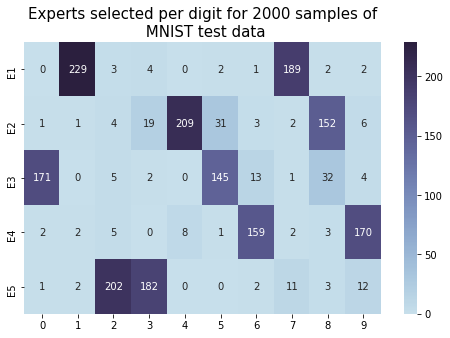

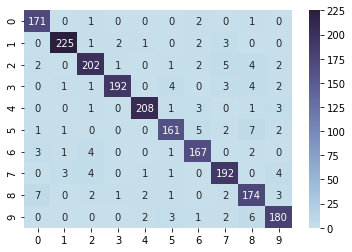

Model 7
20 torch.Size([20, 10000, 5])


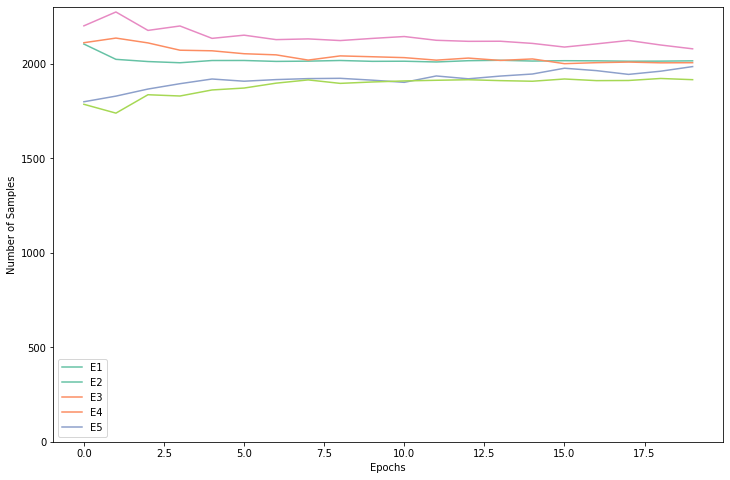

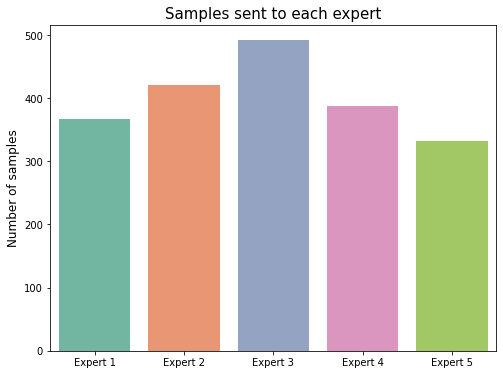

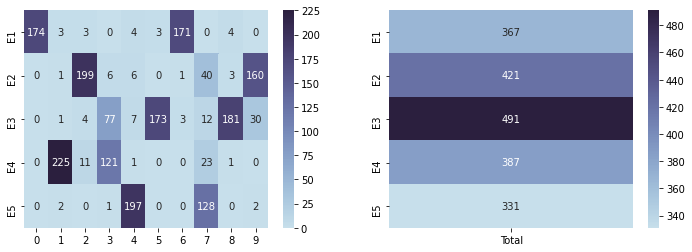


Experts used by the gate for classification of each digit


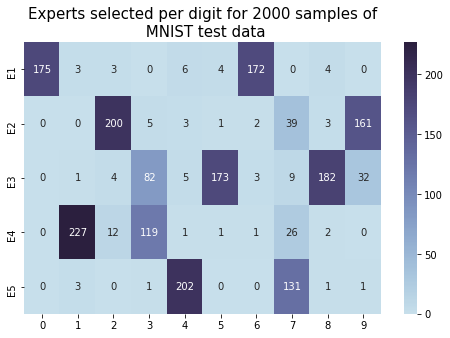

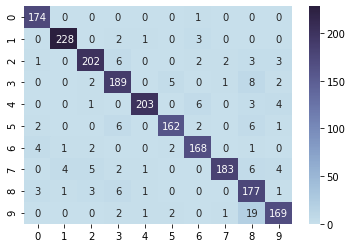

Model 8
20 torch.Size([20, 10000, 5])


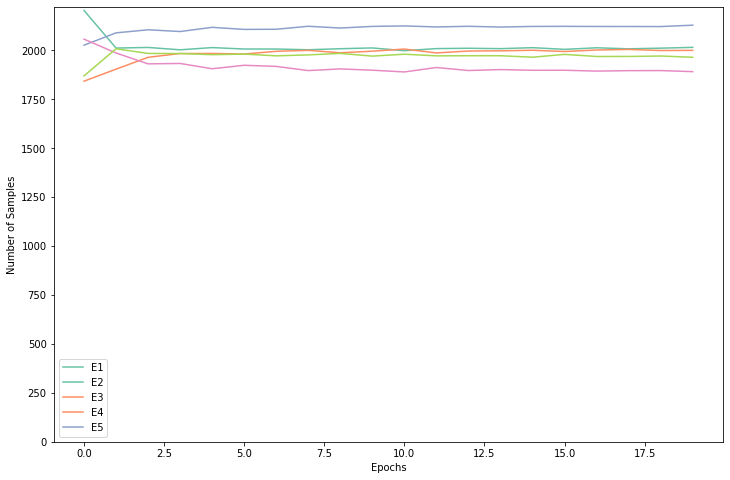

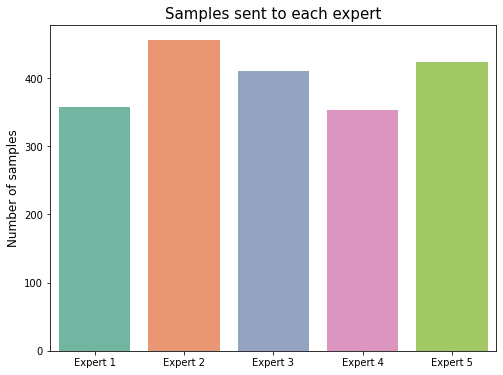

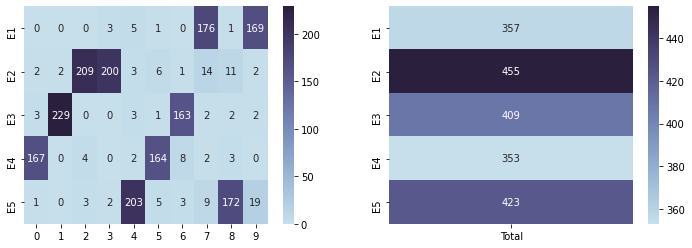


Experts used by the gate for classification of each digit


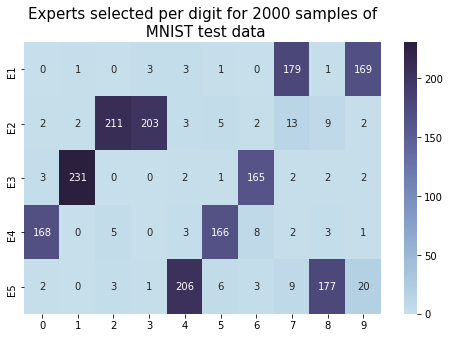

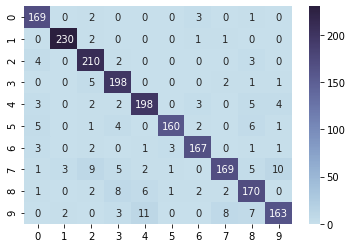

Model 9
20 torch.Size([20, 10000, 5])


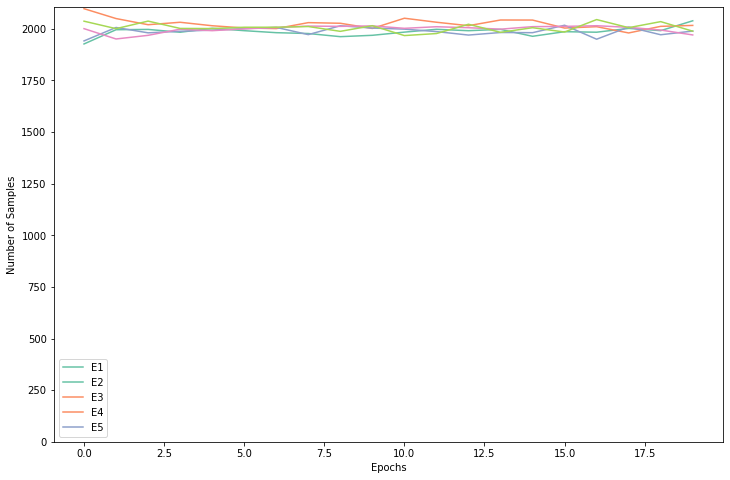

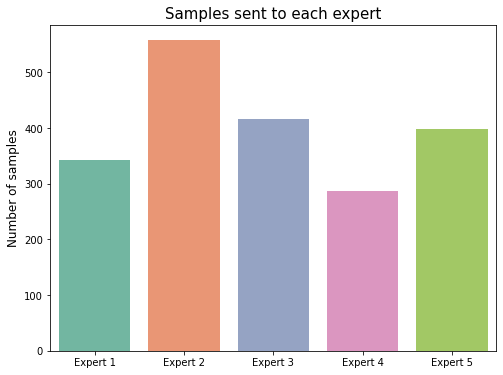

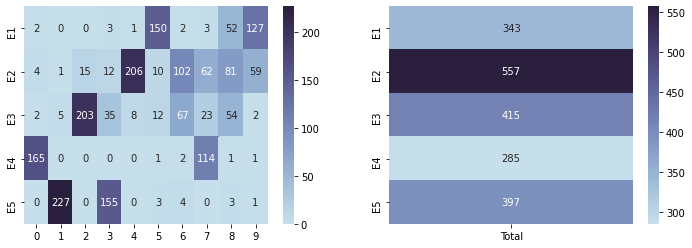


Experts used by the gate for classification of each digit


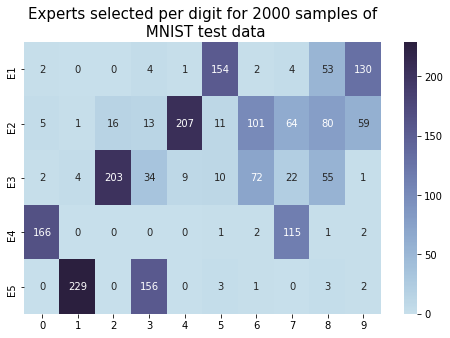

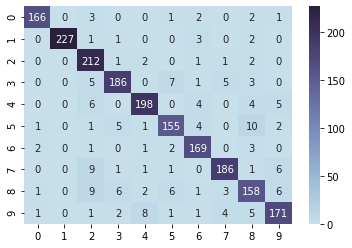

In [66]:
from sklearn.metrics import confusion_matrix
# m1 = 'mnist_imbalanced_5_dual_temp'
# m1 = 'mnist_dual_temp'
# m1 = 'fmnist_mnist_dual_temp'
# m1 = 'fmnist_mnist_with_reg'
# m1 = 'mnist_dual_temp_with_reg'
# m1 = 'mnist_dual_temp_with_regularization'
# m1 = 'mnist_dual_temp_on_schedule'
# m1 = 'mnist_dual_temp_output_reg'
# m1 = 'mnist_output_imp_reg'
# m2 = 'mnist_imbalanced_5_with_regularization'
# m1 = 'mnist_with_reg'
# m1 = 'mnist_without_reg'
m1 = 'mnist_with_attention_hidden_32'
m1 = 'mnist_with_attn_reg_hidden_32'
# m2 = 'mnist_with_reg_test'
m2 = None

test_loader = testloader
# test_loader = fmnist_mnist_testloader
# test_loader = imbalanced_trainloader_all

# total_experts = 6
# num_epochs = 20
# num_classes = num_classes_fmnist_mnist
# classes = classes_fmnist_mnist

total_experts = 5
num_epochs = 20
num_classes = 10
classes = list(range(num_classes))

w_ortho = 0.0
w_importance = 1.0
w_sample_sim = 0.0
w_exp_gamma = 0.0
temp = 1.0

fontsize = 15
fontsize_label = 12

plot_file = generate_plot_file(m1, temp=temp, w_importance=w_importance, w_ortho=w_ortho, 
                               w_sample_sim=w_sample_sim, w_exp_gamma=w_exp_gamma,
                               specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

print(plot_file)

model_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

for i, model in enumerate(model_1):
    print('Model',i)
    

    for e_key, e_val in model.items():
        history = model[e_key]['experts'][total_experts]['history']
        gate_probabilities = history['gate_probabilities']
        gate_probabilities = torch.stack(gate_probabilities)
        
        print(len(gate_probabilities), gate_probabilities.shape)
        
        gate_probabilities_sum = torch.sum(gate_probabilities, dim =1).cpu().detach().numpy()        

        fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(12, 8))
        
        palette = sns.color_palette("Set2")
        for i in range(total_experts):
            sns.lineplot(x=range(num_epochs), y=gate_probabilities_sum[:,i], 
                         hue=[i]*num_epochs, palette=palette[i:i+1], ax=ax)
        ax.set_ylim(bottom=0)
        plt.xlabel('Epochs')
        plt.ylabel('Number of Samples')
        plt.legend(['E'+str(i+1) for i in range(5)])
        plt.show()
        
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
        with torch.no_grad(): 
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']
                
                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs
                
                fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8, 6))
                x = ['Expert '+str(i+1) for i in range(total_experts)]
                y = torch.sum(gate_outputs, dim=0).cpu().numpy()
                
                sns.barplot(x=x, y=y, palette=palette, ax=ax)
                
                plt.ylabel('Number of samples', fontsize=fontsize_label)
                ax.tick_params(axis='both', labelsize=10)
                
                plt.title('Samples sent to each expert', fontsize=fontsize)
                plot_file = generate_plot_file(m1, temp=temp, w_importance=w_importance, w_sample_sim=w_sample_sim, specific=str(num_classes)+'_'+str(total_experts)+'_expert_usage.png')             
                plt.savefig(os.path.join(fig_path, plot_file))
                plt.show()
                                
                exp_class_prob = torch.zeros(total_experts, num_classes).to(device)
                for e in range(total_experts):
                    for index, l in enumerate(labels):
                        exp_class_prob[e,l] += gate_outputs[index,e]  
                  
                exp_total_prob = torch.sum(exp_class_prob, dim=1).view(-1,1).to(device)
                
                fig,ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12,4))
               
                sns.heatmap(exp_class_prob.cpu().numpy().astype(int), yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                                xticklabels=[classes[i] for i in range(0, num_classes)],
                                cmap=cmap, annot=True, fmt='d', ax=ax[0])
                sns.heatmap(exp_total_prob.cpu().numpy().astype(int), yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                                xticklabels=['Total'],
                                cmap=cmap, annot=True, fmt='d', ax=ax[1])
                plt.show()
                    
                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1

                
                fig1,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8, 5))
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax)
                
                plt.title('Experts selected per digit for 2000 samples of\n MNIST test data', 
                                 fontsize=fontsize)
                plot_file = generate_plot_file(m1, temp=temp, w_importance=w_importance, w_sample_sim=w_sample_sim, specific=str(num_classes)+'_'+str(total_experts)+'_class_expert_table.png')             
                plt.savefig(os.path.join(fig_path, plot_file))

                fig1,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6, 4))
                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, cmap=cmap, fmt='d', ax=ax)

                plt.show()



Model 0
20 torch.Size([20, 10000, 5])


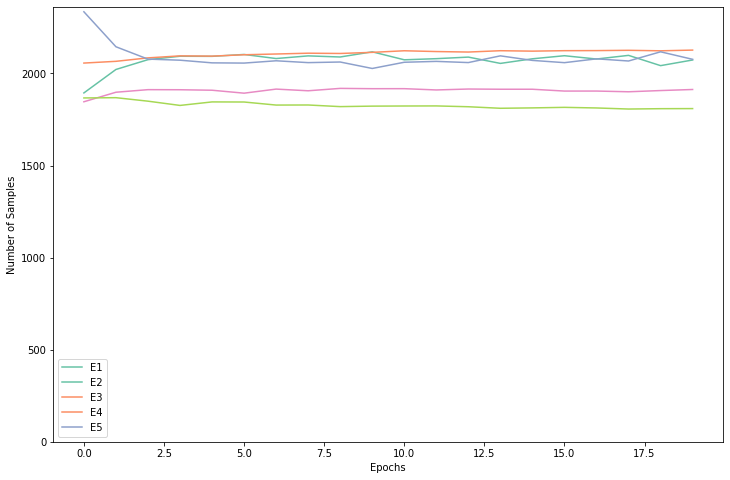

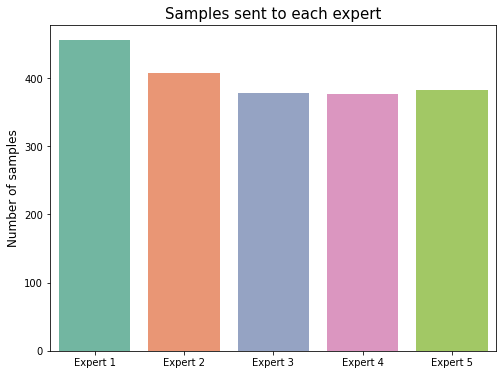

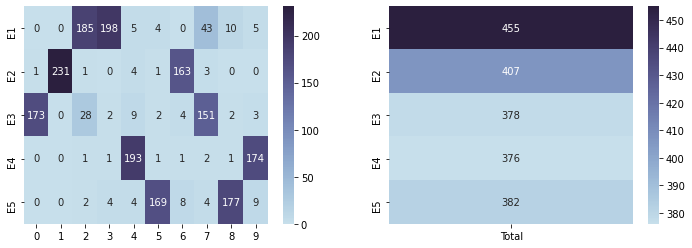


Experts used by the gate for classification of each digit


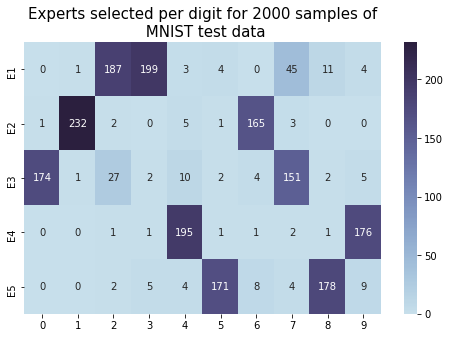

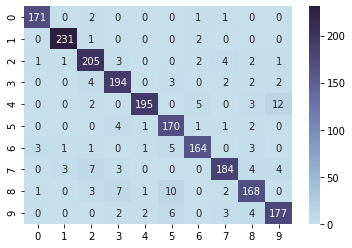

Model 1
20 torch.Size([20, 10000, 5])


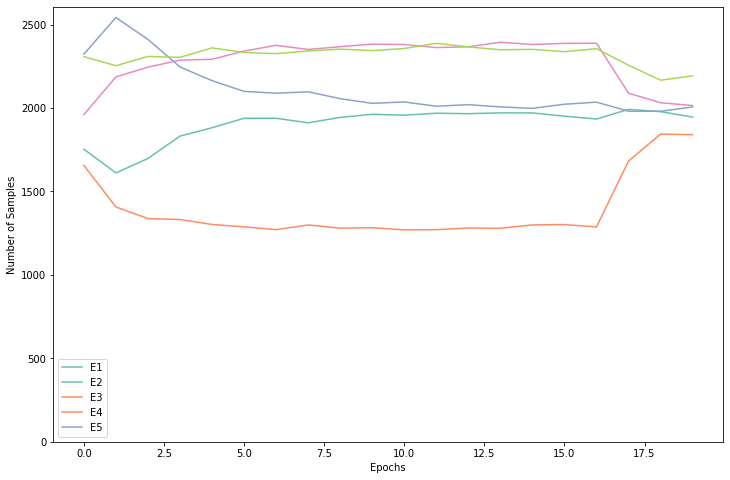

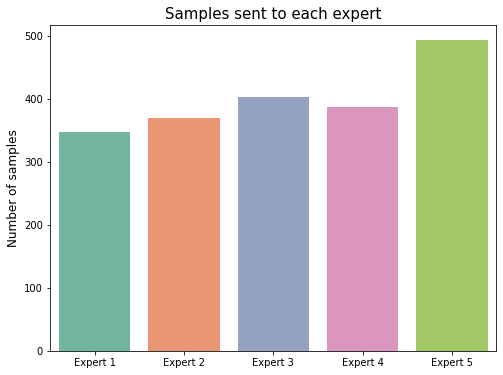

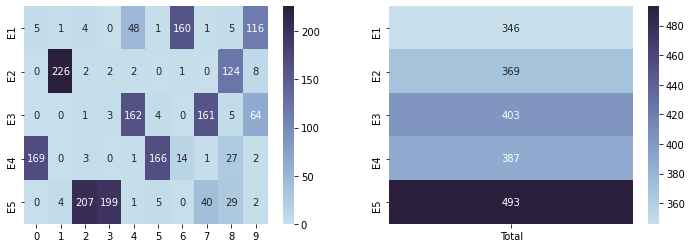


Experts used by the gate for classification of each digit


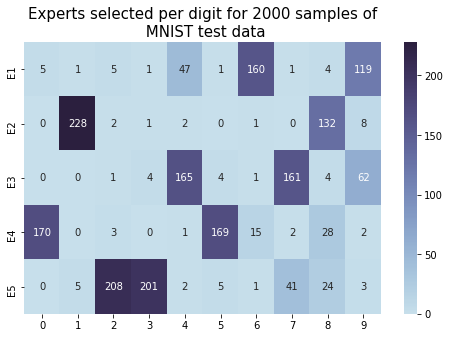

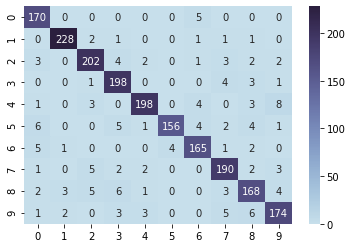

Model 2
20 torch.Size([20, 10000, 5])


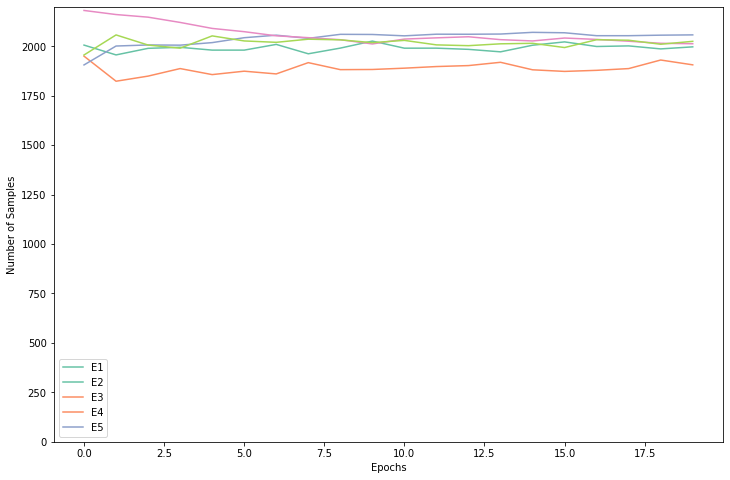

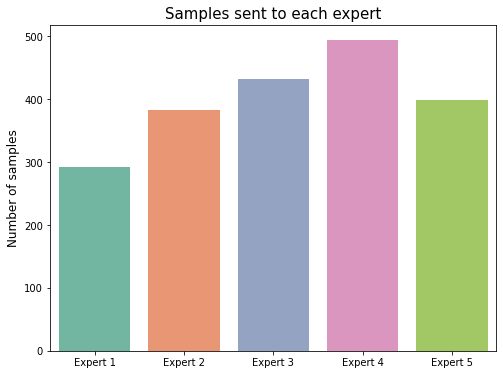

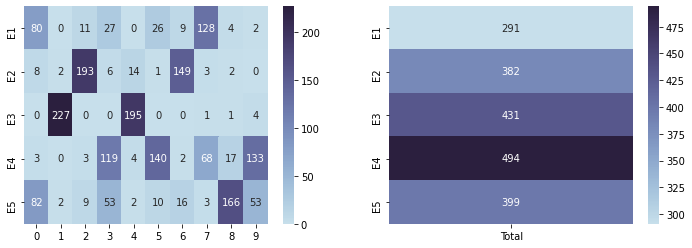


Experts used by the gate for classification of each digit


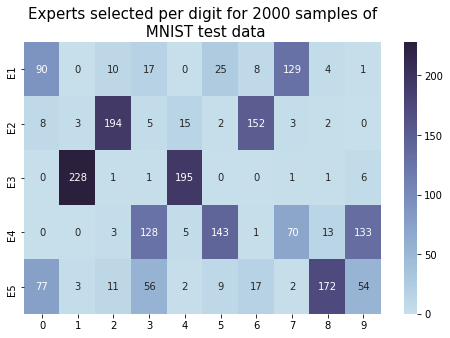

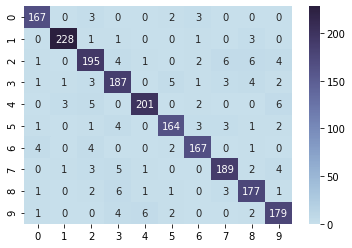

Model 3
20 torch.Size([20, 10000, 5])


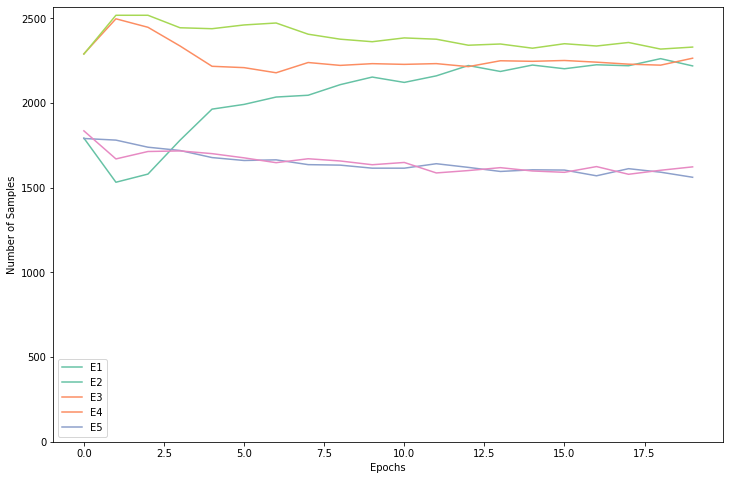

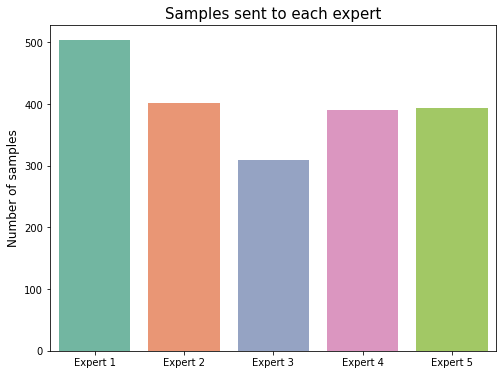

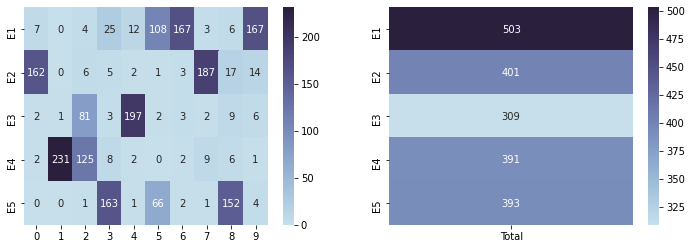


Experts used by the gate for classification of each digit


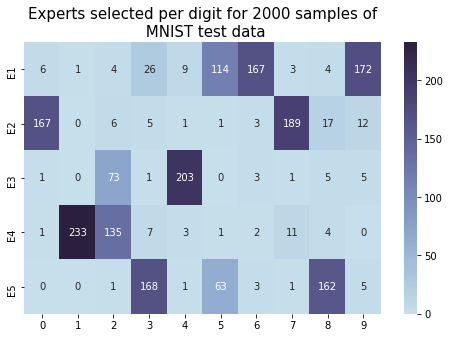

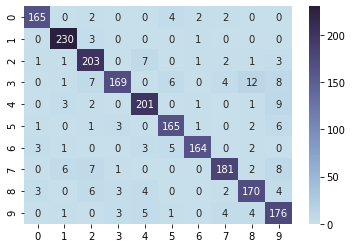

Model 4
20 torch.Size([20, 10000, 5])


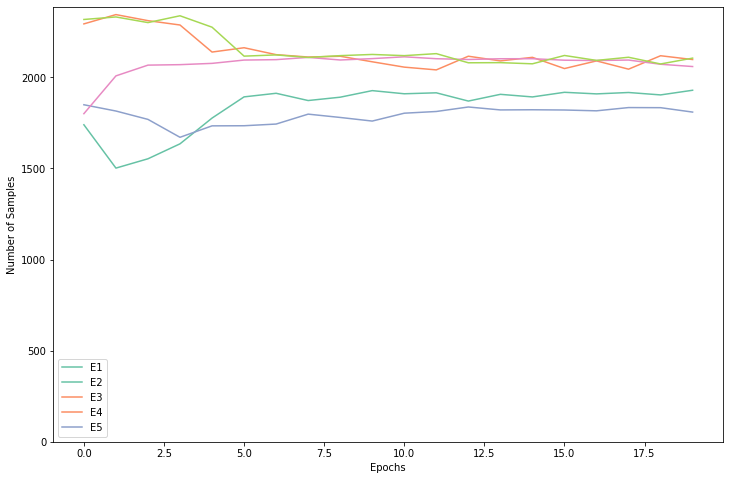

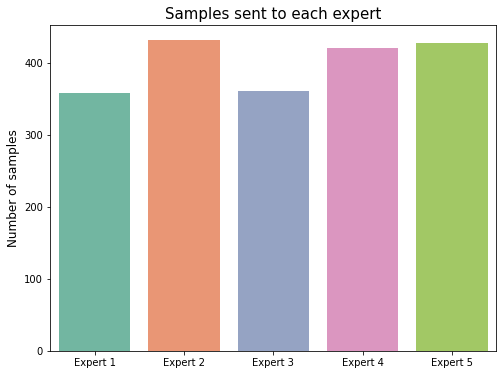

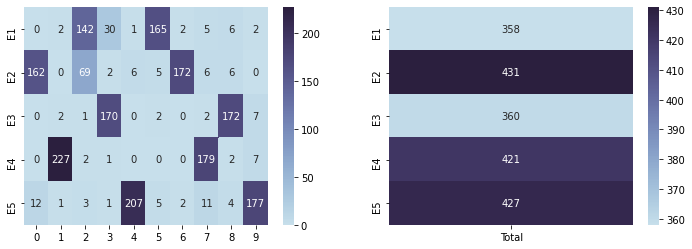


Experts used by the gate for classification of each digit


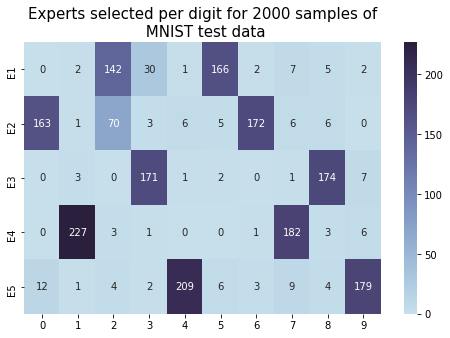

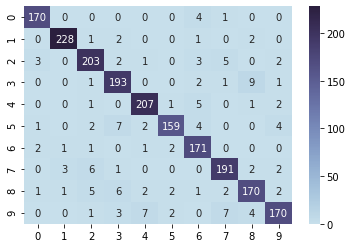

Model 5
20 torch.Size([20, 10000, 5])


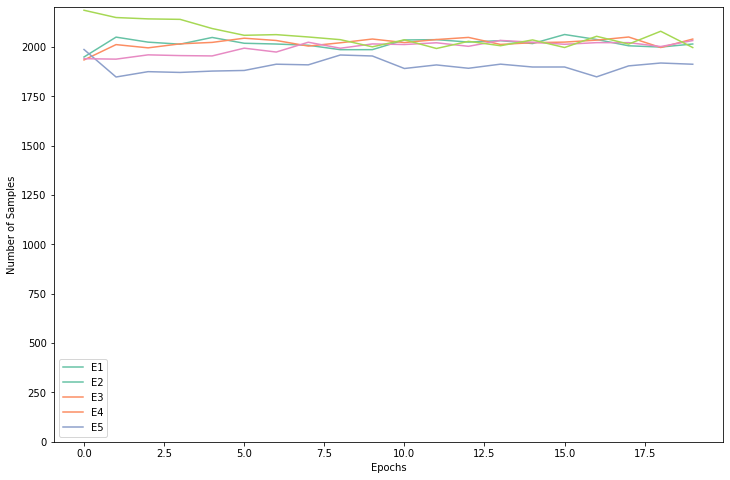

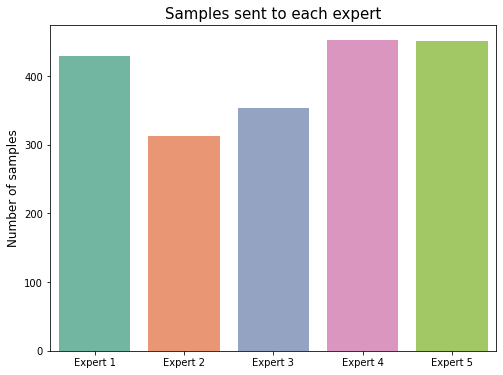

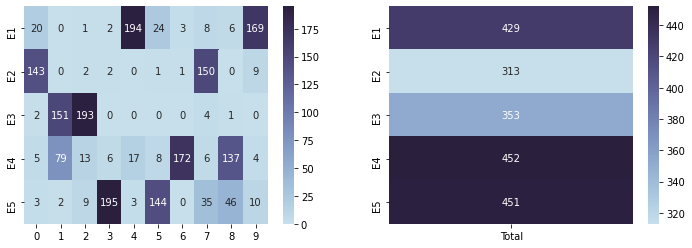


Experts used by the gate for classification of each digit


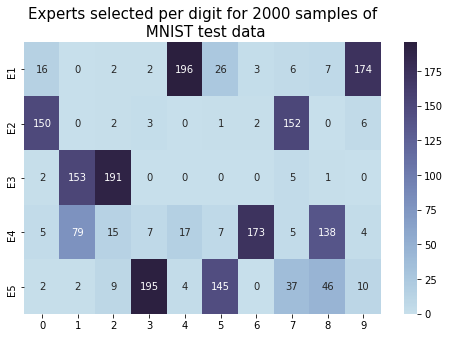

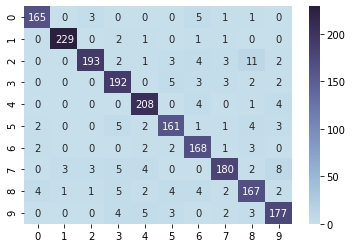

Model 6
20 torch.Size([20, 10000, 5])


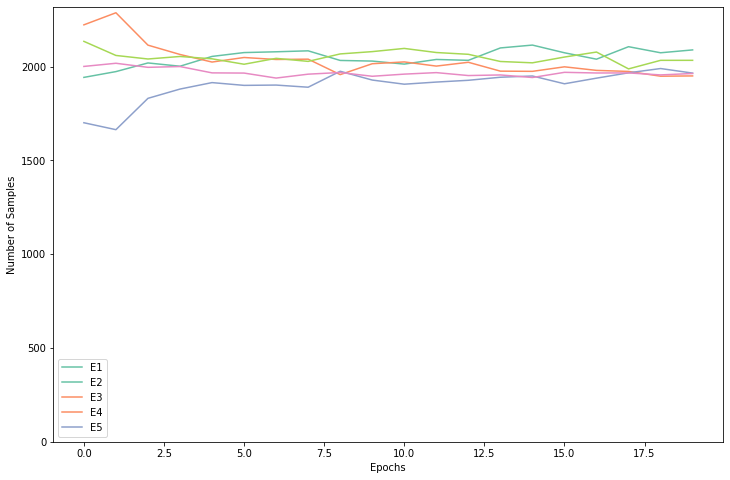

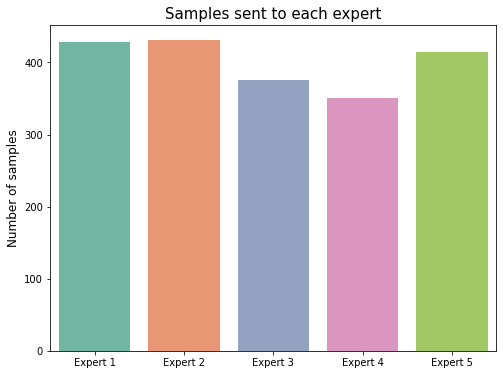

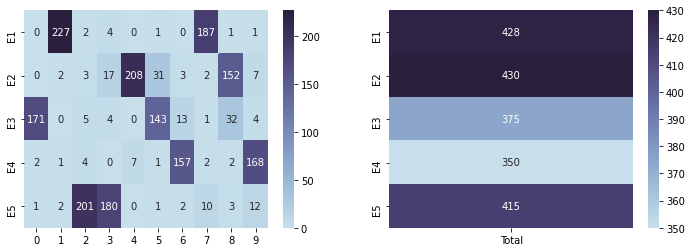


Experts used by the gate for classification of each digit


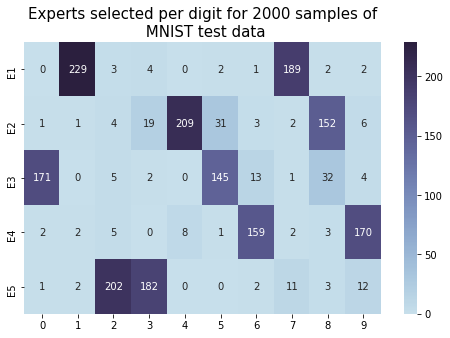

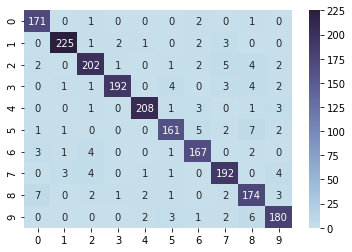

Model 7
20 torch.Size([20, 10000, 5])


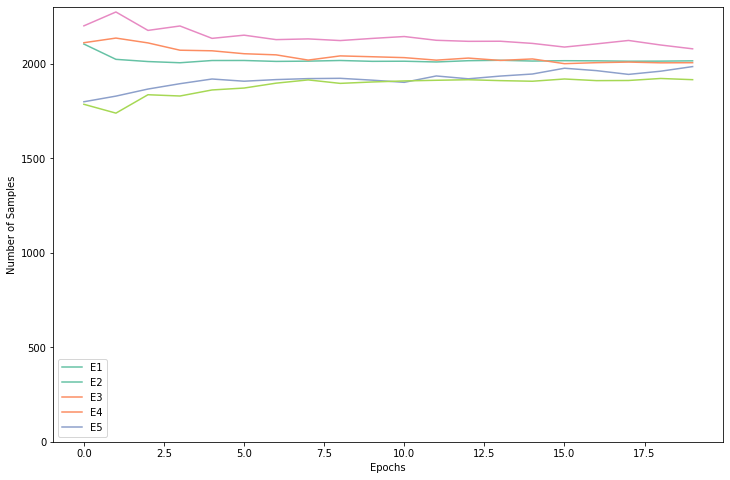

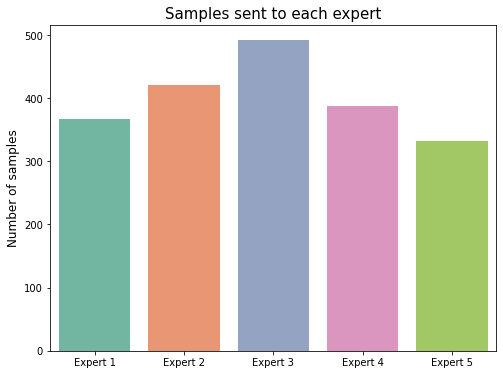

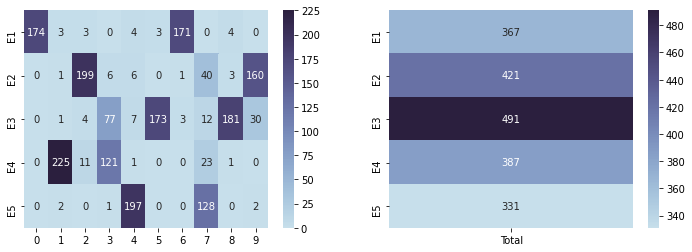


Experts used by the gate for classification of each digit


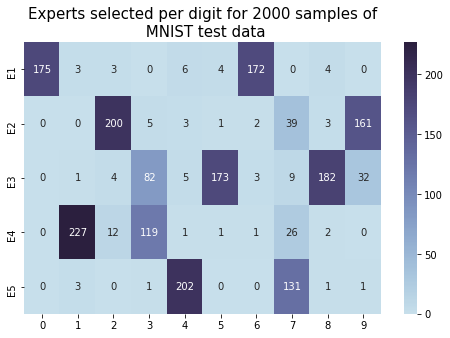

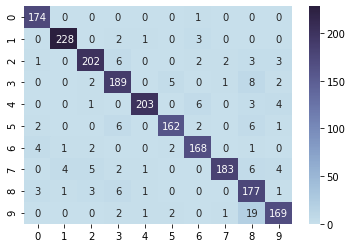

Model 8
20 torch.Size([20, 10000, 5])


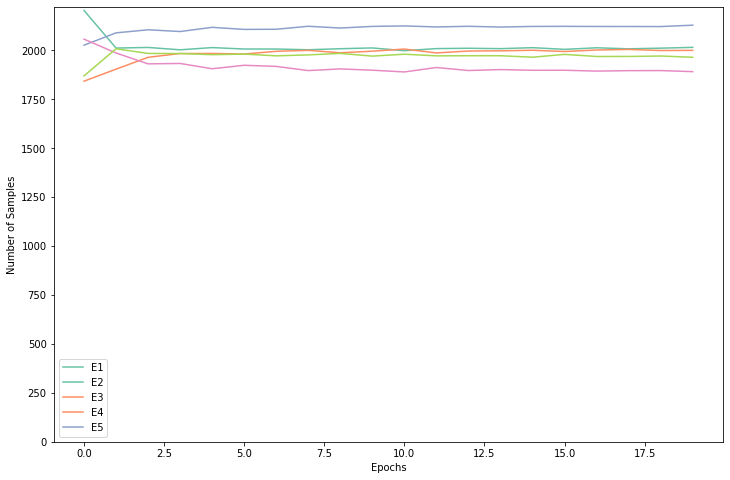

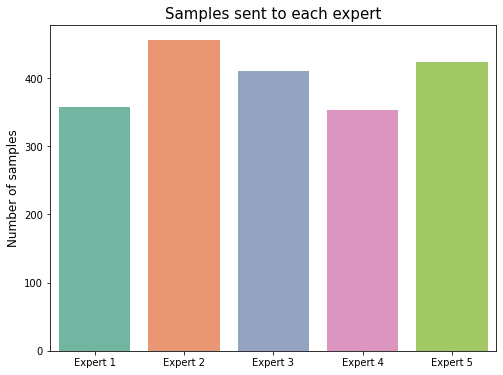

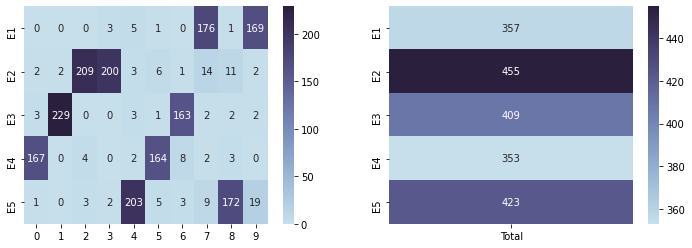


Experts used by the gate for classification of each digit


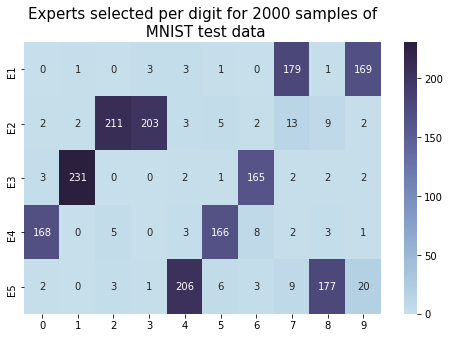

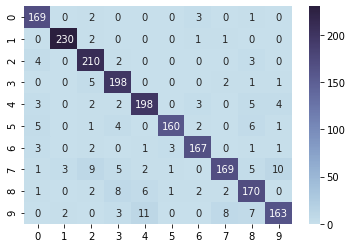

Model 9
20 torch.Size([20, 10000, 5])


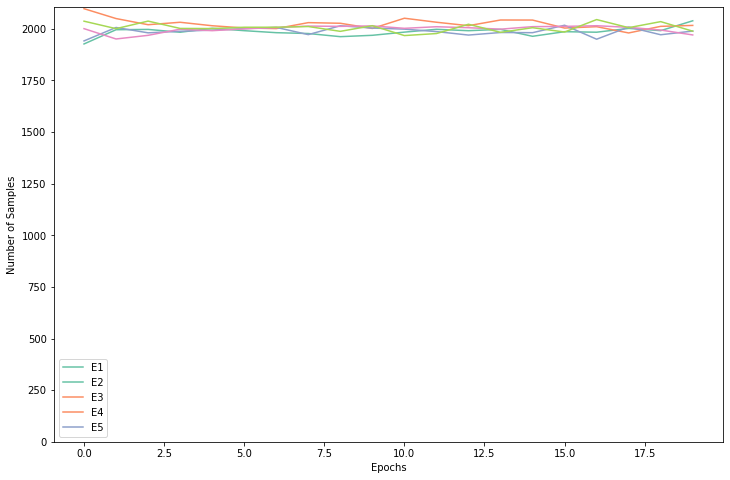

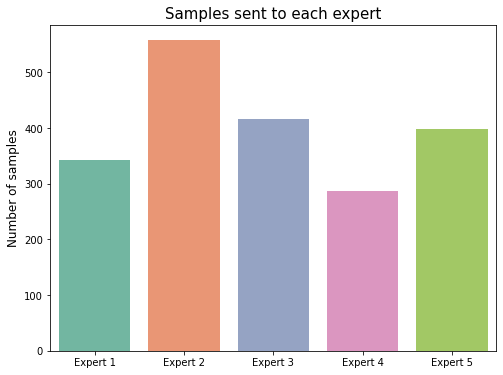

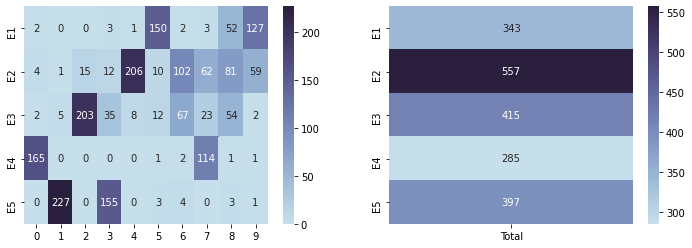


Experts used by the gate for classification of each digit


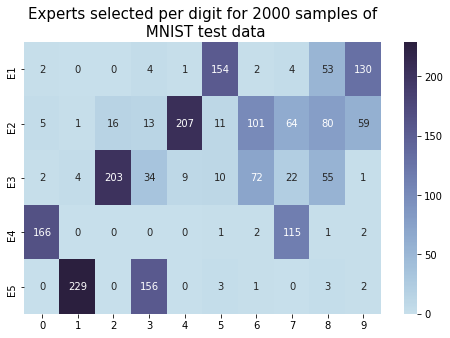

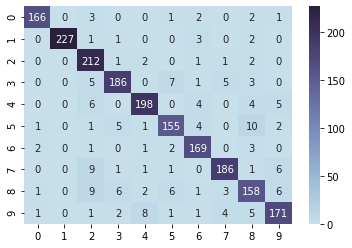

In [99]:
from sklearn.metrics import confusion_matrix
# m1 = 'mnist_imbalanced_5_dual_temp'
# m1 = 'mnist_dual_temp'
# m1 = 'fmnist_mnist_dual_temp'
# m1 = 'fmnist_mnist_with_reg'
# m1 = 'mnist_dual_temp_with_reg_test'
# m1 = 'mnist_dual_temp_with_regularization'
# m1 = 'mnist_dual_temp_on_schedule'
# m1 = 'mnist_dual_temp_output_reg'
# m1 = 'mnist_output_imp_reg'
# m1 = 'mnist_with_reg_hidden_32'
# m1 = 'mnist_without_reg'
# m1 = 'mnist_with_attention_hidden_32'
m1 = 'mnist_with_attn_reg_hidden_32'
# m2 = 'mnist_with_reg_test'
m2 = None

test_loader = testloader
# test_loader = fmnist_mnist_testloader
# test_loader = imbalanced_trainloader_all

# total_experts = 6
# num_epochs = 20
# num_classes = num_classes_fmnist_mnist
# classes = classes_fmnist_mnist

total_experts = 5
num_epochs = 20
num_classes = 10
classes = list(range(num_classes))

w_ortho = 0.0
w_importance = 1.0
w_sample_sim = 0.0
w_exp_gamma = 0.0
temp = 1.0

fontsize = 15
fontsize_label = 12

plot_file = generate_plot_file(m1, temp=temp, w_importance=w_importance, w_ortho=w_ortho, 
                               w_sample_sim=w_sample_sim, w_exp_gamma=w_exp_gamma,
                               specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

model_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

for i, model in enumerate(model_1):
    print('Model',i)
    

    for e_key, e_val in model.items():
        history = model[e_key]['experts'][total_experts]['history']
        gate_probabilities = history['gate_probabilities']
        gate_probabilities = torch.stack(gate_probabilities)
        
        print(len(gate_probabilities), gate_probabilities.shape)
        
        gate_probabilities_sum = torch.sum(gate_probabilities, dim =1).cpu().detach().numpy()        

        fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(12, 8))
        
        palette = sns.color_palette("Set2")
        for i in range(total_experts):
            sns.lineplot(x=range(num_epochs), y=gate_probabilities_sum[:,i], 
                         hue=[i]*num_epochs, palette=palette[i:i+1], ax=ax)
        ax.set_ylim(bottom=0)
        plt.xlabel('Epochs')
        plt.ylabel('Number of Samples')
        plt.legend(['E'+str(i+1) for i in range(5)])
        plt.show()
        
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
        with torch.no_grad(): 
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']
                
                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs
                
                fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8, 6))
                x = ['Expert '+str(i+1) for i in range(total_experts)]
                y = torch.sum(gate_outputs, dim=0).cpu().numpy()
                
                sns.barplot(x=x, y=y, palette=palette, ax=ax)
                
                plt.ylabel('Number of samples', fontsize=fontsize_label)
                ax.tick_params(axis='both', labelsize=10)
                
                plt.title('Samples sent to each expert', fontsize=fontsize)
                plot_file = generate_plot_file(m1, temp=temp, w_importance=w_importance, w_sample_sim=w_sample_sim, specific=str(num_classes)+'_'+str(total_experts)+'_expert_usage.png')             
                plt.savefig(os.path.join(fig_path, plot_file))
                plt.show()
                                
                exp_class_prob = torch.zeros(total_experts, num_classes).to(device)
                for e in range(total_experts):
                    for index, l in enumerate(labels):
                        exp_class_prob[e,l] += gate_outputs[index,e]  
                  
                exp_total_prob = torch.sum(exp_class_prob, dim=1).view(-1,1).to(device)
                
                fig,ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12,4))
               
                sns.heatmap(exp_class_prob.cpu().numpy().astype(int), yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                                xticklabels=[classes[i] for i in range(0, num_classes)],
                                cmap=cmap, annot=True, fmt='d', ax=ax[0])
                sns.heatmap(exp_total_prob.cpu().numpy().astype(int), yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                                xticklabels=['Total'],
                                cmap=cmap, annot=True, fmt='d', ax=ax[1])
                plt.show()
                    
                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1

                
                fig1,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8, 5))
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax)
                
                plt.title('Experts selected per digit for 2000 samples of\n MNIST test data', 
                                 fontsize=fontsize)
                plot_file = generate_plot_file(m1, temp=temp, w_importance=w_importance, w_sample_sim=w_sample_sim, specific=str(num_classes)+'_'+str(total_experts)+'_class_expert_table.png')             
                plt.savefig(os.path.join(fig_path, plot_file))

                fig1,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6, 4))
                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, cmap=cmap, fmt='d', ax=ax)

                plt.show()



In [60]:
from helper.moe_models import entropy

def expert_usage_entropy(history, num_epochs=20):
    gate_probability = torch.vstack(history['gate_probabilities']).view(num_epochs, -1, total_experts)
    gate_probabilities_sum = torch.mean(gate_probability, dim=1)
    return entropy(gate_probabilities_sum[-1]).item()


In [61]:
def boxplot(model_single=None, model_with_temp=None,model_with_temp_decay=None, 
            model_with_reg=None, model_without_reg=None, model_with_reg_temp=None, 
            model_with_attention=None, model_with_attn_reg=None, model_dual_temp_with_attention = None, 
            model_output_reg =None, model_output_imp_reg=None,model_temp_output_reg=None, 
            mnist_attn_output_reg=None, model_sample_sim_reg=None,
            temps=[1.0], w_importance_range=[0.0], w_ortho_range=[0.0], w_sample_sim_range=[0.0],
            total_experts=5, num_classes=10, classes=None, testloader=None, figname=None):

    x = []
    hues = []
    x_temp = []
    y_error = []
    y_val_error = []
    y_mi = []
    y_H_EY = []
    y_sample_H = []
    y_sample_H_T = []
    y_sample_hue = []
    y_expert_usage = []

    w_importance = 0.0
    
    if not model_single is None:
        m = model_single

        plot_file = generate_plot_file(m, specific=str(num_classes)+'_models.pt')

        model_0 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

        for history in model_0['history']:
            error = [e.item() for e in 1-np.asarray(history['accuracy'])]
            val_error = [e.item() for e in 1-np.asarray(history['val_accuracy'])]
            y_error.append(error[-1])
            y_val_error.append(val_error[-1])
            x.append('SM')
            hues.append('Single Model')
    
    if not model_without_reg is None:
        m = model_without_reg

        plot_file = generate_plot_file(m, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

        model_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

        for model in model_1:
            for e_key, e_val in model.items():
                history = model[e_key]['experts'][total_experts]['history']
                error = 1-np.asarray(history['accuracy'])
                val_error = 1-np.asarray(history['val_accuracy'])
                y_error.append(error[-1])
                y_val_error.append(val_error[-1])
                y_mi.append(history['mutual_EY'][-1])
                y_H_EY.append(history['H_EY'][-1])
                y_sample_H.append(history['sample_entropy'][-1])
                y_expert_usage.append(expert_usage_entropy(history))
                x.append('I 0.0')
                hues.append('MoE')
      
    if not model_with_reg is None:
        m = model_with_reg

        for w_importance in w_importance_range:
            
            plot_file = generate_plot_file(m, w_importance=w_importance, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            model_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

            for model in model_2:
                for e_key, e_val in model.items():
                    history = model[e_key]['experts'][total_experts]['history']
                    error = 1-np.asarray(history['accuracy'])
                    val_error = 1-np.asarray(history['val_accuracy'])
                    y_error.append(error[-1])
                    y_val_error.append(val_error[-1])
                    y_mi.append(history['mutual_EY'][-1])
                    y_H_EY.append(history['H_EY'][-1])
                    y_sample_H.append(history['sample_entropy'][-1])
                    y_expert_usage.append(expert_usage_entropy(history))
                    x.append('I '+"{:.1f}".format(w_importance))
                    hues.append('MoE with regularization')


    w_importance = 0.0
    
    if not model_with_temp is None:
    
        m = model_with_temp

        for T in temps:   

            plot_file = generate_plot_file(m, temp=T, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')


            # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
            # model you build above
            model_3 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

            for model in model_3:
                for e_key, e_val in model.items():
                    history = model[e_key]['experts'][total_experts]['history']
                    error = 1-np.asarray(history['accuracy'])
                    val_error = 1-np.asarray(history['val_accuracy'])
                    y_error.append(error[-1])
                    y_val_error.append(val_error[-1])
                    y_mi.append(history['mutual_EY'][-1])
                    y_H_EY.append(history['H_EY'][-1])
                    y_sample_H.append(history['sample_entropy'][-1])
                    y_expert_usage.append(expert_usage_entropy(history))
                    y_sample_H_T.append(history['sample_entropy'][-1])
                    y_sample_H_T.append(history['sample_entropy_T'][-1])
                    x.append('T '+"{:.1f}".format(T))
                    x_temp.append('T '+"{:.1f}".format(T))
                    x_temp.append('T '+"{:.1f}".format(T))
                    y_sample_hue.append('Low Temp')
                    y_sample_hue.append('High Temp')               
                    hues.append('Moe with dual temp')

    if not model_with_temp_decay is None:
        m = model_with_temp_decay

        for T in temps:   

            plot_file = generate_plot_file(m, temp=T, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')


            # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
            # model you build above
            model_3 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

            for model in model_3:
                for e_key, e_val in model.items():
                    history = model[e_key]['experts'][total_experts]['history']
                    error = 1-np.asarray(history['accuracy'])
                    val_error = 1-np.asarray(history['val_accuracy'])
                    y_error.append(error[-1])
                    y_val_error.append(val_error[-1])
                    y_mi.append(history['mutual_EY'][-1])
                    y_H_EY.append(history['H_EY'][-1])
                    y_sample_H.append(history['sample_entropy'][-1])
                    y_expert_usage.append(expert_usage_entropy(history))
                    x.append('T '+"{:.1f}".format(T)+' D')
                    hues.append('Moe with dual temp on decay')

    
    if not model_with_reg_temp is None:
        m = model_with_reg_temp

        for T, w_importance in product(temps, w_importance_range):   

            plot_file = generate_plot_file(m, temp=T, w_importance=w_importance, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
            # model you build above
            model_4 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

            for model in model_4:
                for e_key, e_val in model.items():
                    history = model[e_key]['experts'][total_experts]['history']
                    error = 1-np.asarray(history['accuracy'])
                    val_error = 1-np.asarray(history['val_accuracy'])
                    y_error.append(error[-1])
                    y_val_error.append(val_error[-1])
                    y_mi.append(history['mutual_EY'][-1])
                    y_H_EY.append(history['H_EY'][-1])
                    y_sample_H.append(history['sample_entropy'][-1])
                    y_expert_usage.append(expert_usage_entropy(history))
                    x.append('T '+"{:.1f}".format(T)+'+ I '+"{:.1f}".format(w_importance))
                    hues.append('Moe with reg and dual temp')
                
    if not model_output_reg is None:
        m = model_output_reg

        for w_ortho in w_ortho_range:

            plot_file = generate_plot_file(m, w_ortho=w_ortho, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            model_5 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

            for model in model_5:
                for e_key, e_val in model.items():
                    history = model[e_key]['experts'][total_experts]['history']
                    error = 1-np.asarray(history['accuracy'])
                    val_error = 1-np.asarray(history['val_accuracy'])
                    y_error.append(error[-1])
                    y_val_error.append(val_error[-1])
                    y_mi.append(history['mutual_EY'][-1])
                    y_H_EY.append(history['H_EY'][-1])
                    y_sample_H.append(history['sample_entropy'][-1])
                    y_expert_usage.append(expert_usage_entropy(history))
                    x.append('O '+"{:.1f}".format(w_ortho))
                    hues.append('MoE with output regularization')
    
    if not model_output_imp_reg is None:
        m = model_output_imp_reg

        for w_ortho, w_importance in product(w_ortho_range, w_importance_range):

            plot_file = generate_plot_file(m, w_importance=w_importance, w_ortho=w_ortho, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            model_5 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

            for model in model_5:
                for e_key, e_val in model.items():
                    history = model[e_key]['experts'][total_experts]['history']
                    error = 1-np.asarray(history['accuracy'])
                    val_error = 1-np.asarray(history['val_accuracy'])
                    y_error.append(error[-1])
                    y_val_error.append(val_error[-1])
                    y_mi.append(history['mutual_EY'][-1])
                    y_H_EY.append(history['H_EY'][-1])
                    y_sample_H.append(history['sample_entropy'][-1])
                    y_expert_usage.append(expert_usage_entropy(history))
                    x.append('I '+"{:.1f}".format(w_importance) + ' + O '+"{:.1f}".format(w_ortho))
                    hues.append('MoE with output and gate regularization')
                    

                
    if not model_temp_output_reg is None:
        m = model_temp_output_reg

        for T, w_ortho in product(temps, w_ortho_range):   

            plot_file = generate_plot_file(m, temp=T,w_ortho=w_ortho, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
            # model you build above
            model_4 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

            for model in model_4:
                for e_key, e_val in model.items():
                    history = model[e_key]['experts'][total_experts]['history']
                    error = 1-np.asarray(history['accuracy'])
                    val_error = 1-np.asarray(history['val_accuracy'])
                    y_error.append(error[-1])
                    y_val_error.append(val_error[-1])
                    y_mi.append(history['mutual_EY'][-1])
                    y_H_EY.append(history['H_EY'][-1])
                    y_sample_H.append(history['sample_entropy'][-1])
                    y_expert_usage.append(expert_usage_entropy(history))
                    x.append('T '+"{:.1f}".format(T)+'+ O '+"{:.1f}".format(w_ortho))
                    hues.append('Moe with outputreg and dual temp')
    
    if not model_with_attention is None:
        
        m = model_with_attention

        plot_file = generate_plot_file(m, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

        model_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

        for model in model_1:
            for e_key, e_val in model.items():
                history = model[e_key]['experts'][total_experts]['history']
                error = 1-np.asarray(history['accuracy'])
                val_error = 1-np.asarray(history['val_accuracy'])
                y_error.append(error[-1])
                y_val_error.append(val_error[-1])
                y_mi.append(history['mutual_EY'][-1])
                y_H_EY.append(history['H_EY'][-1])
                y_sample_H.append(history['sample_entropy'][-1])
                y_expert_usage.append(expert_usage_entropy(history))
                x.append('Attention')
                hues.append('MoE with attention')
                
    if not model_with_attn_reg is None:
        m = model_with_attn_reg
 
        for w_importance in w_importance_range:
            
            plot_file = generate_plot_file(m, w_importance=w_importance, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            model_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
            
            for model in model_2:
                for e_key, e_val in model.items():
                    history = model[e_key]['experts'][total_experts]['history']
                    error = 1-np.asarray(history['accuracy'])
                    val_error = 1-np.asarray(history['val_accuracy'])
                    y_error.append(error[-1])
                    y_val_error.append(val_error[-1])
                    y_mi.append(history['mutual_EY'][-1])
                    y_H_EY.append(history['H_EY'][-1])
                    y_sample_H.append(history['sample_entropy'][-1])
                    y_expert_usage.append(expert_usage_entropy(history))
                    x.append('Attn + I '+"{:.1f}".format(w_importance))
                    hues.append('MoE with attention and regularization')
    
    
    if not  model_dual_temp_with_attention is None:

        m = model_dual_temp_with_attention

        for T in temps:   

            plot_file = generate_plot_file(m, temp=T, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')


            # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
            # model you build above
            model_3 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

            for model in model_3:
                for e_key, e_val in model.items():
                    history = model[e_key]['experts'][total_experts]['history']
                    error = 1-np.asarray(history['accuracy'])
                    val_error = 1-np.asarray(history['val_accuracy'])
                    y_error.append(error[-1])
                    y_val_error.append(val_error[-1])
                    y_mi.append(history['mutual_EY'][-1])
                    y_H_EY.append(history['H_EY'][-1])
                    y_sample_H.append(history['sample_entropy'][-1])
                    y_expert_usage.append(expert_usage_entropy(history))
                    y_sample_H_T.append(history['sample_entropy'][-1])
                    y_sample_H_T.append(history['sample_entropy_T'][-1])
                    x.append('Attn + T '+"{:.1f}".format(T))
                    x_temp.append('Attn + T '+"{:.1f}".format(T))
                    x_temp.append('Attn + T '+"{:.1f}".format(T))
                    y_sample_hue.append('Low Temp')
                    y_sample_hue.append('High Temp')               
                    hues.append('Moe with dual temp and attention')
                    
    if not mnist_attn_output_reg is None:
        m = mnist_attn_output_reg

        for w_ortho in w_ortho_range:
            
            plot_file = generate_plot_file(m, w_ortho=w_ortho, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            model_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

            for model in model_2:
                for e_key, e_val in model.items():
                    history = model[e_key]['experts'][total_experts]['history']
                    error = 1-np.asarray(history['accuracy'])
                    val_error = 1-np.asarray(history['val_accuracy'])
                    y_error.append(error[-1])
                    y_val_error.append(val_error[-1])
                    y_mi.append(history['mutual_EY'][-1])
                    y_H_EY.append(history['H_EY'][-1])
                    y_sample_H.append(history['sample_entropy'][-1])
                    y_expert_usage.append(expert_usage_entropy(history))
                    x.append('Attn + O '+"{:.1f}".format(w_ortho))
                    hues.append('MoE with attention and output reg')
                    
    if not model_sample_sim_reg is None:
        m = model_sample_sim_reg

        for w_sample_sim in w_sample_sim_range:
            
            plot_file = generate_plot_file(m, w_sample_sim=w_sample_sim, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            model_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

            error_values = []
            for model in model_2:
                for e_key, e_val in model.items():
                    history = model[e_key]['experts'][total_experts]['history']
                    error = 1-np.asarray(history['accuracy'])
                    val_error = 1-np.asarray(history['val_accuracy'])
                    y_error.append(error[-1])
                    y_val_error.append(val_error[-1])
                    y_mi.append(history['mutual_EY'][-1])
                    y_H_EY.append(history['H_EY'][-1])
                    y_sample_H.append(history['sample_entropy'][-1])
                    y_expert_usage.append(expert_usage_entropy(history))
                    x.append('SS '+"{:.1f}".format(w_sample_sim))
                    hues.append('MoE with sample sim reg')

            
    palette = sns.color_palette("Set2")
    fontsize = 20
    labelsize = 15
    plt.tight_layout()
    
    
    _, indices = np.unique(np.asarray(x), return_index=True)
    xlabels = np.asarray(x)[sorted(indices)]
    
    fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(20, 8))
    sns.boxplot(x=x, y=y_error, hue=hues, palette=palette, dodge=False, ax=ax)
    ax.set_title('Comparing training errors for different MoE training methods', fontsize=fontsize)
    ax.set_xlabel('MoE training methods', fontsize=labelsize)
    ax.set_ylabel('training error', fontsize=labelsize)      
    ax.set_xticklabels(xlabels, rotation='vertical')
    ax.tick_params(axis='both', labelsize=12)
    plt.legend(fontsize=labelsize)

    plot_file = generate_plot_file(figname, specific='training_error_boxplot.png')             
    plt.savefig(os.path.join(fig_path, plot_file),bbox_inches='tight')
    
    plt.show()
    
    fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(20, 8))
    sns.boxplot(x=x, y=y_val_error, hue=hues,palette=palette, dodge=False, ax=ax)
    ax.set_title('Comparing validation errors for different MoE training methods', fontsize=fontsize)
    ax.set_ylabel('validation error', fontsize=labelsize)
    ax.set_xlabel('MoE training methods', fontsize=labelsize)
    ax.set_xticklabels(xlabels, rotation='vertical')
    ax.tick_params(axis='both', labelsize=12)
    plt.legend(fontsize=labelsize)
    
    plot_file = generate_plot_file(figname, specific='val_error_boxplot.png')             
    plt.savefig(os.path.join(fig_path, plot_file),bbox_inches='tight')
    plt.show()
    
    if not model_single is None:
        x = x[10:]
        hues = hues[10:]
        palette = palette[1:]
        xlabels = xlabels[1:]
        
    fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(20, 8))
    sns.boxplot(x=x, y=y_mi, hue=hues, palette=palette, dodge=False,ax=ax)
    ax.set_title('Comparing joint mutual information of experts $E$ and MoE model output $Y$ for different MoE training methods', fontsize=fontsize)
    ax.set_ylabel('EY mutual information', fontsize=labelsize)  
    ax.set_xlabel('MoE training methods', fontsize=labelsize)
    ax.set_xticklabels(xlabels, rotation='vertical')
    ax.tick_params(axis='both', labelsize=12)
    plt.legend(fontsize=labelsize)

    plot_file = generate_plot_file(figname, specific='mutual_info_boxplot.png')             
    plt.savefig(os.path.join(fig_path, plot_file),bbox_inches='tight')
    
    plt.show()
    
#     fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(12, 8))
#     sns.boxplot(x=x, y=y_H_EY, hue=hues, palette=palette, dodge=False,ax=ax)
#     ax.set_ylabel('EY entropy')
#     ax.set_title('EY entropy')
#     ax.set_xticklabels(xlabels, rotation='vertical')
#     plt.savefig(os.path.join(fig_path,'mnist_boxplot_ey_entropy.png'))
#     plt.show()
    
    fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(20, 8))
    sns.boxplot(x=x, y=y_sample_H, hue=hues, palette=palette, dodge=False, ax=ax)
    ax.set_title('Comparing per sample entropy for different MoE training methods', fontsize=fontsize)
    ax.set_ylabel('Per sample entropy', fontsize=labelsize)
    ax.set_xlabel('MoE training methods', fontsize=labelsize)
    ax.set_xticklabels(xlabels, rotation='vertical')
    ax.tick_params(axis='both', labelsize=12)
    plt.legend(fontsize=labelsize)

    plot_file = generate_plot_file(figname, specific='sample_entropy_boxplot.png')             
    plt.savefig(os.path.join(fig_path, plot_file),bbox_inches='tight')
    plt.show()
    
    fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(20, 8))
    sns.boxplot(x=x, y=y_expert_usage, hue=hues, palette=palette, dodge=False, ax=ax)
    ax.set_title('Comparing expert usage entropy for different MoE training methods', fontsize=fontsize)
    ax.set_ylabel('expert usage entropy', fontsize=labelsize)
    ax.set_xlabel('MoE training methods', fontsize=labelsize)
    ax.set_xticklabels(xlabels, rotation='vertical', fontsize=labelsize)
    ax.tick_params(axis='both', labelsize=12)
    plt.legend(fontsize=labelsize)

    plot_file = generate_plot_file(figname, specific='expert_usage_entropy_boxplot.png')             
    plt.savefig(os.path.join(fig_path, plot_file),bbox_inches='tight')
    plt.show()


    if y_sample_H_T:
        palette2 = sns.color_palette("hls", 8)

        fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(12, 8))
        sns.boxplot(x=x_temp, y=y_sample_H_T, hue=y_sample_hue, palette=[palette2[3], palette2[7]], ax=ax)
        ax.set_ylabel('Per sample entropy')
        ax.set_title('per sample entropy for high T')
        plt.show()
        



[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]


<Figure size 432x288 with 0 Axes>

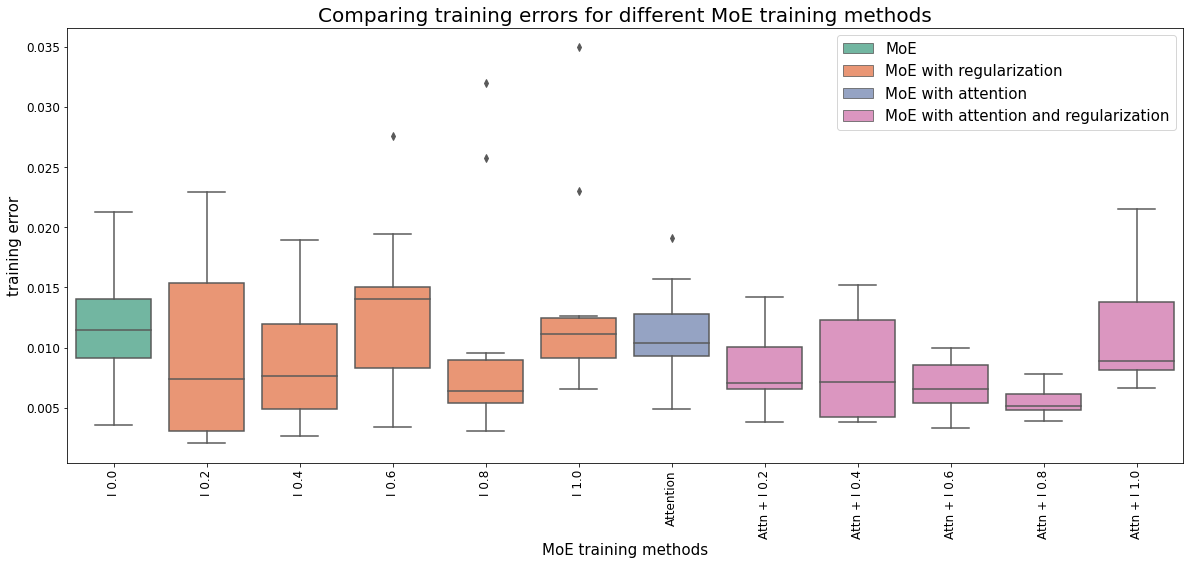

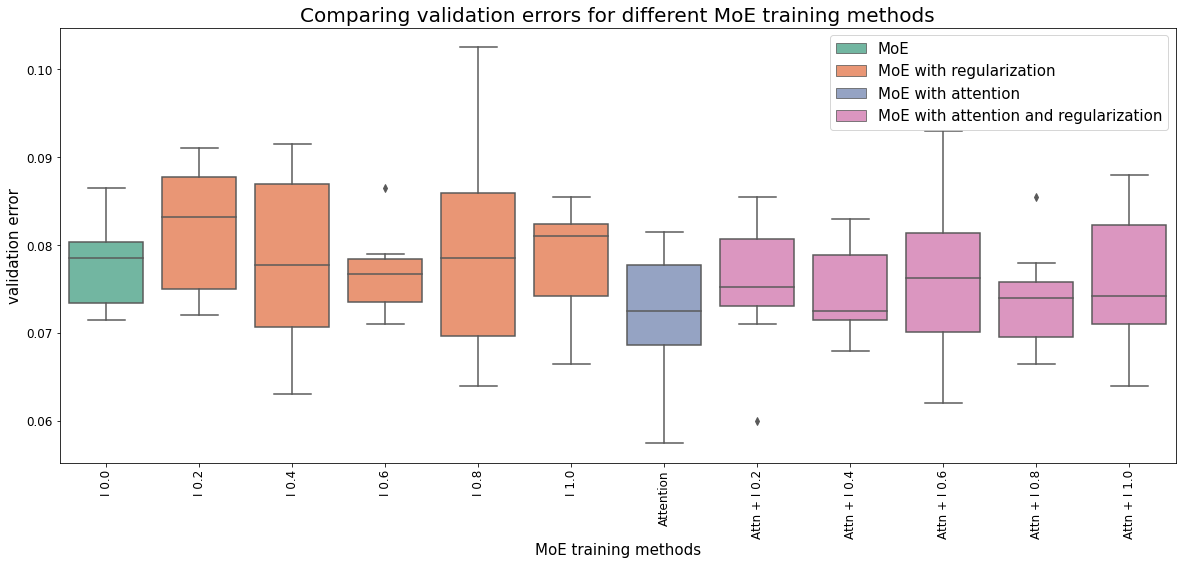

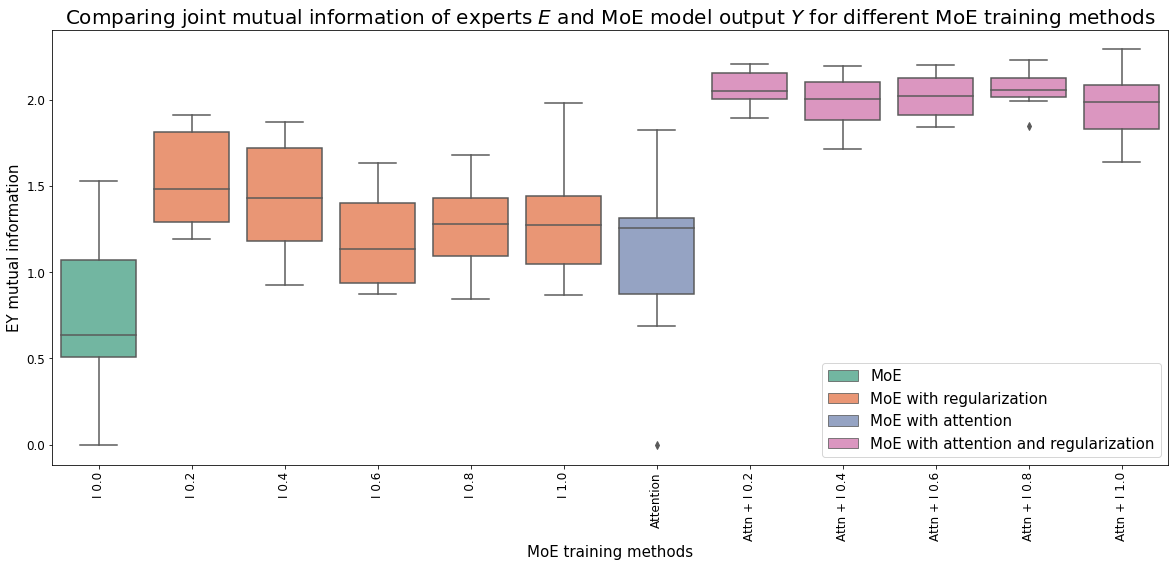

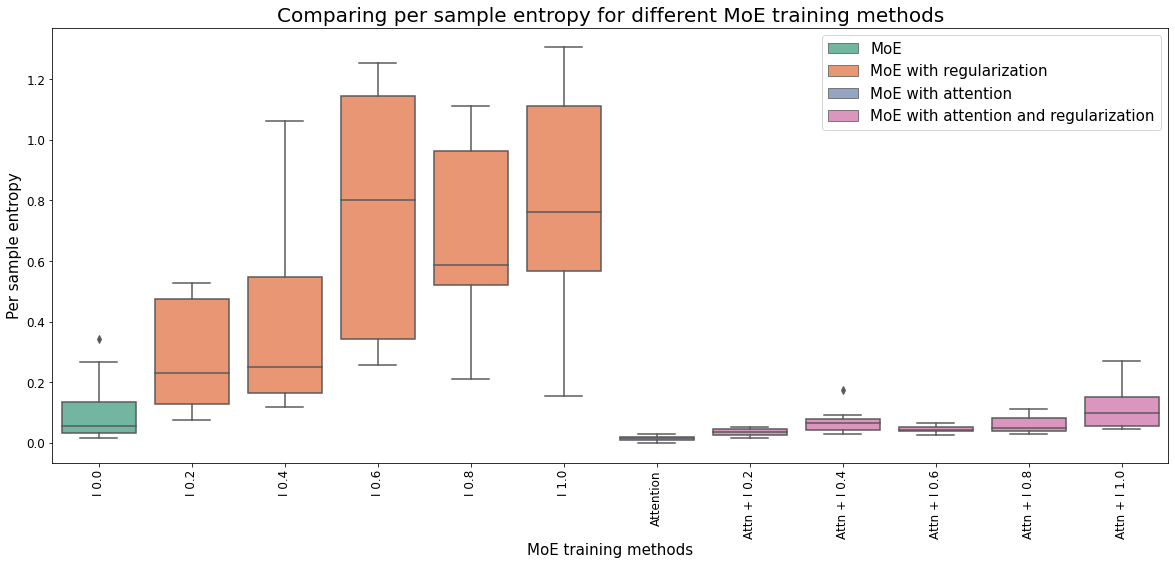

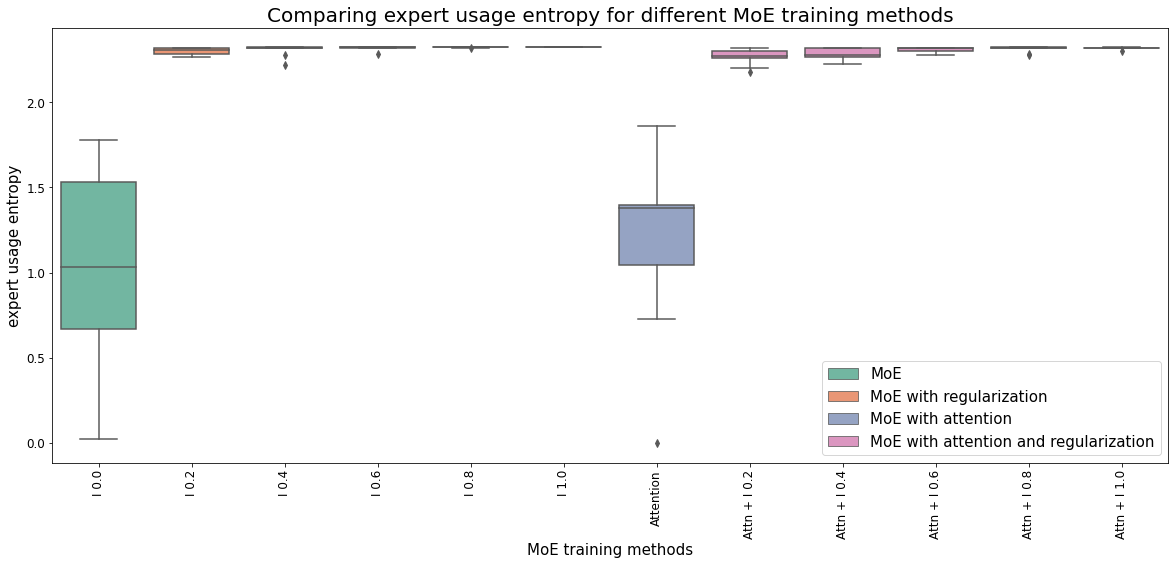

In [80]:
model_without_reg =  model_sample_sim_reg = 'mnist_without_reg_hidden_32'
model_with_reg = 'mnist_with_reg_hidden_32'
model_with_attention = 'mnist_with_attention_hidden_32'
model_with_attn_reg = 'mnist_with_attn_reg_hidden_32'

total_experts = 5
num_classes = 10
num_epochs = 20

temps = [[1.0]*num_epochs]
print(temps)
w_importance_range = [i * 0.2 for i in range(1, 6)]
print(w_importance_range)

boxplot(model_with_reg=model_with_reg, model_without_reg=model_without_reg, 
        model_with_attention=model_with_attention, model_with_attn_reg=model_with_attn_reg,
        temps=temps, w_importance_range=w_importance_range,
        total_experts=total_experts, num_classes=num_classes, classes=range(num_classes), testloader=testloader, figname='mnist_with_attention_hidden_32')

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]


<Figure size 432x288 with 0 Axes>

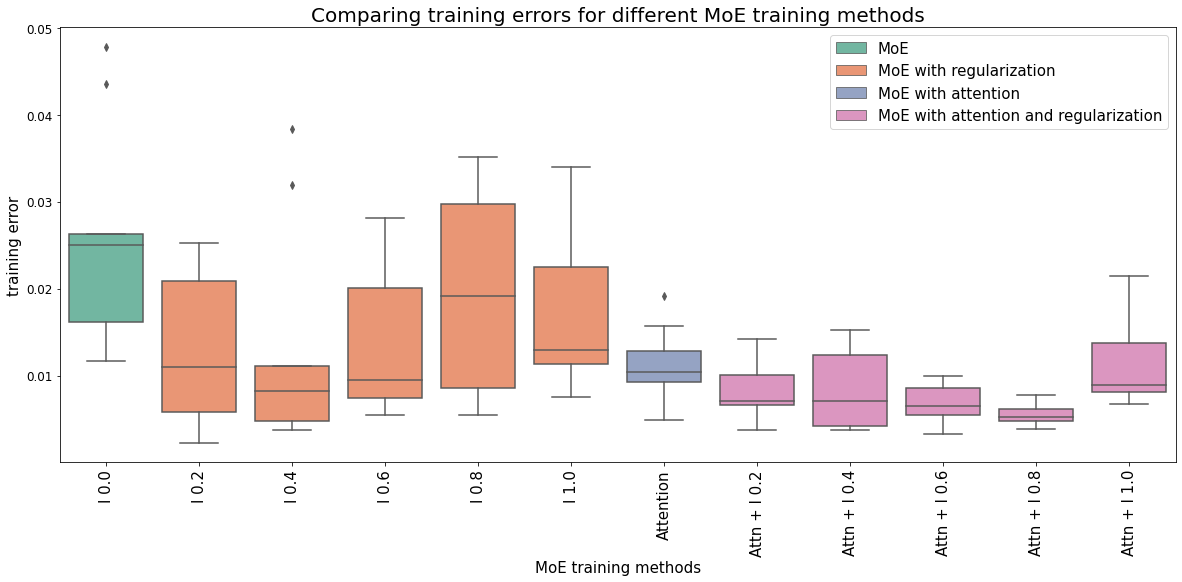

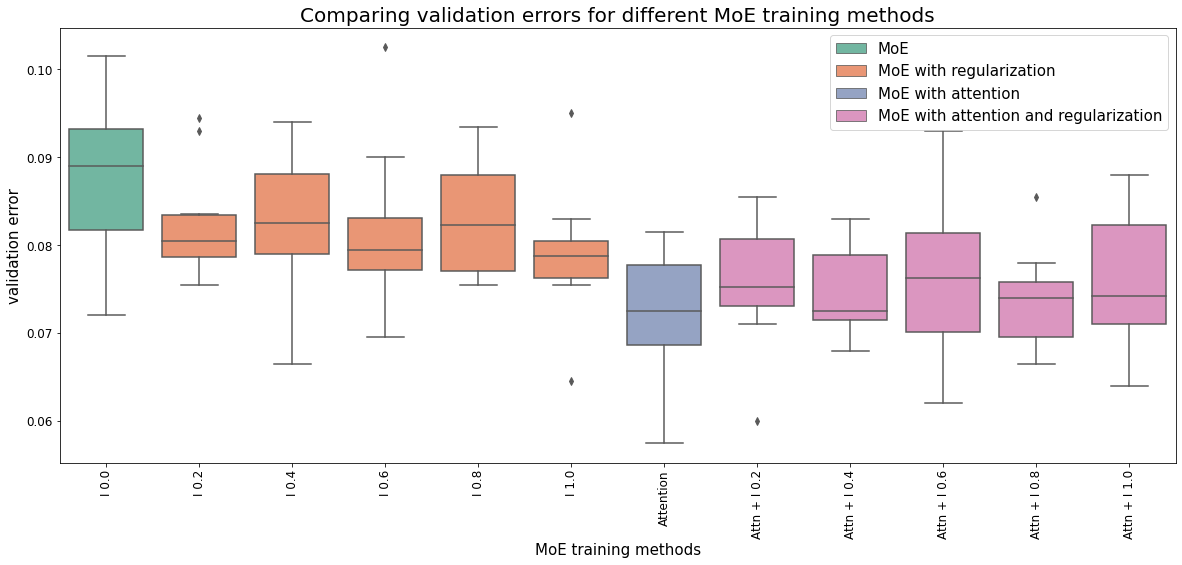

TypeError: unsupported operand type(s) for +=: 'NoneType' and 'str'

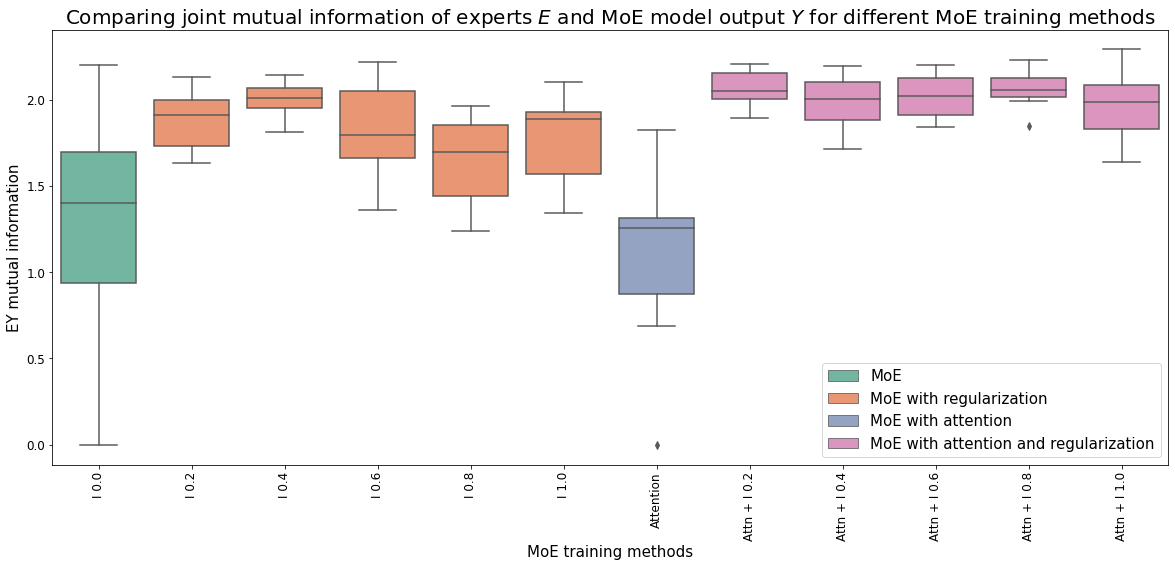

In [86]:
# model_single = 'mnist_single_model_hidden_32'
model_without_reg =  'mnist_without_reg_hidden_32'
model_with_reg = 'mnist_with_reg_hidden_32'
model_with_attention = 'mnist_with_attention_hidden_32'
model_with_attn_reg = 'mnist_with_attn_reg_hidden_32'

total_experts = 5
num_classes = 10
num_epochs = 20

temps = [[1.0]*num_epochs]
print(temps)
w_importance_range = [i * 0.2 for i in range(1, 6)]
print(w_importance_range)

boxplot(model_with_reg=model_with_reg, 
        model_without_reg=model_without_reg, 
        model_with_attention=model_with_attention, 
        model_with_attn_reg=model_with_attn_reg,
        temps=temps, w_importance_range=w_importance_range,
        total_experts=total_experts, num_classes=num_classes, classes=range(num_classes), testloader=testloader)


[1.1 1.2 1.3 1.4 1.5]
[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]


<Figure size 432x288 with 0 Axes>

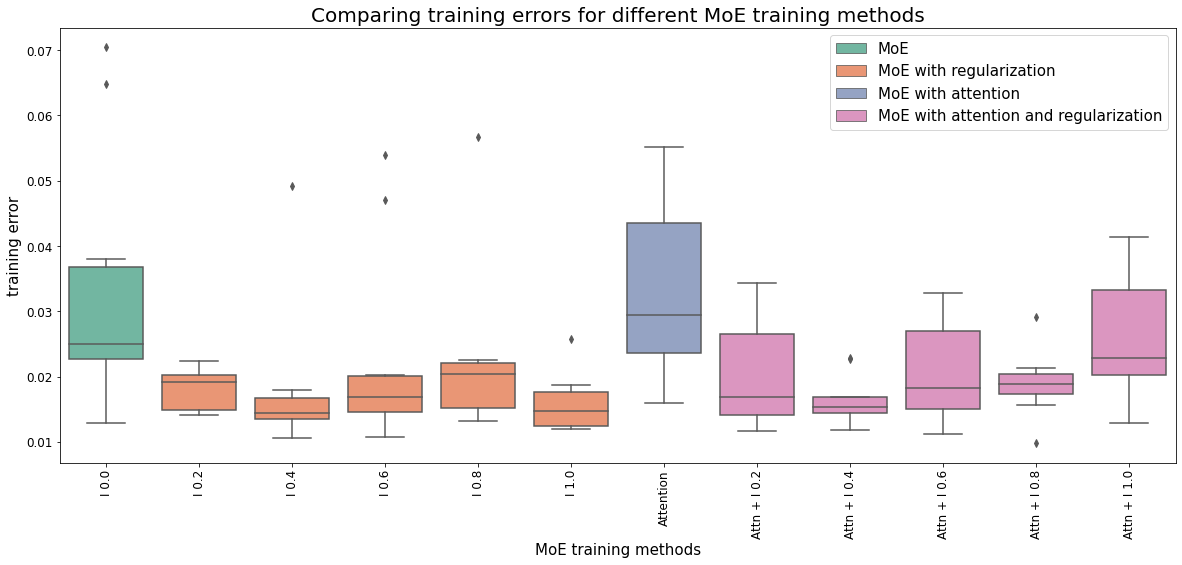

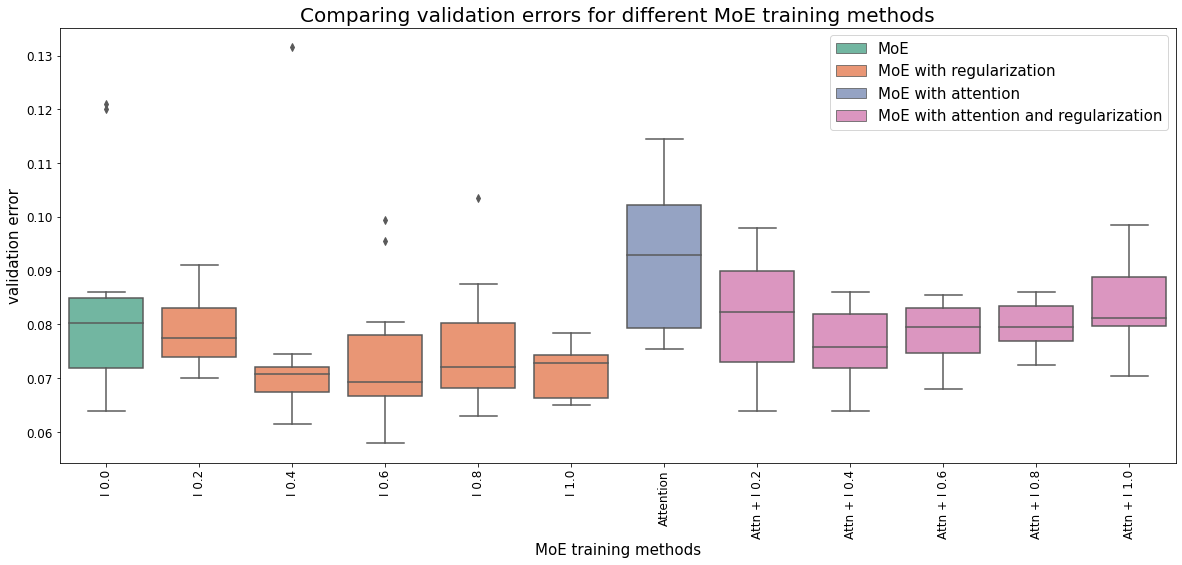

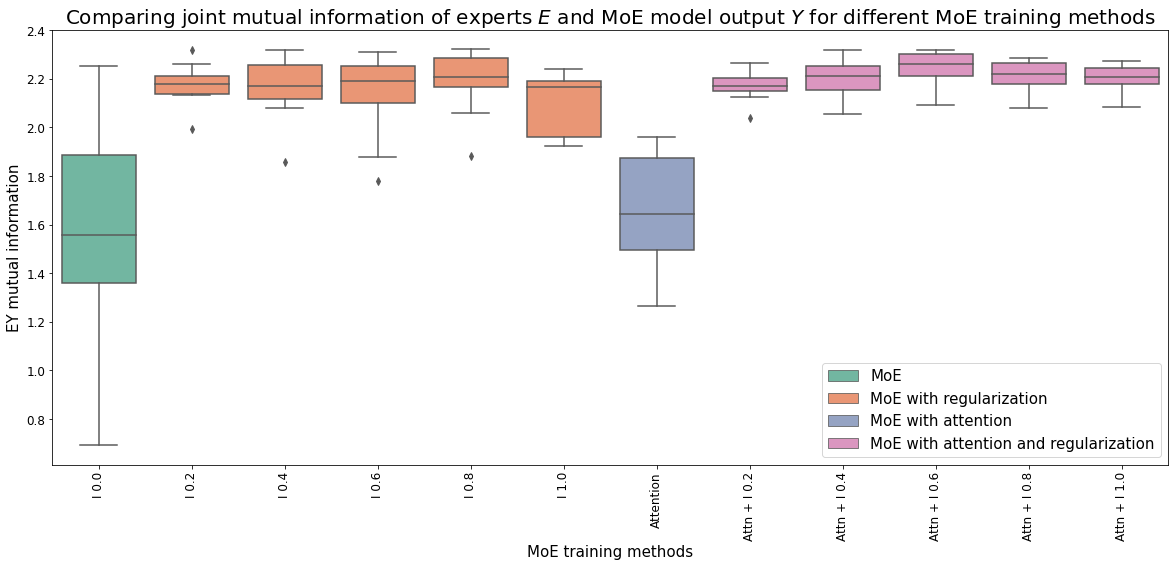

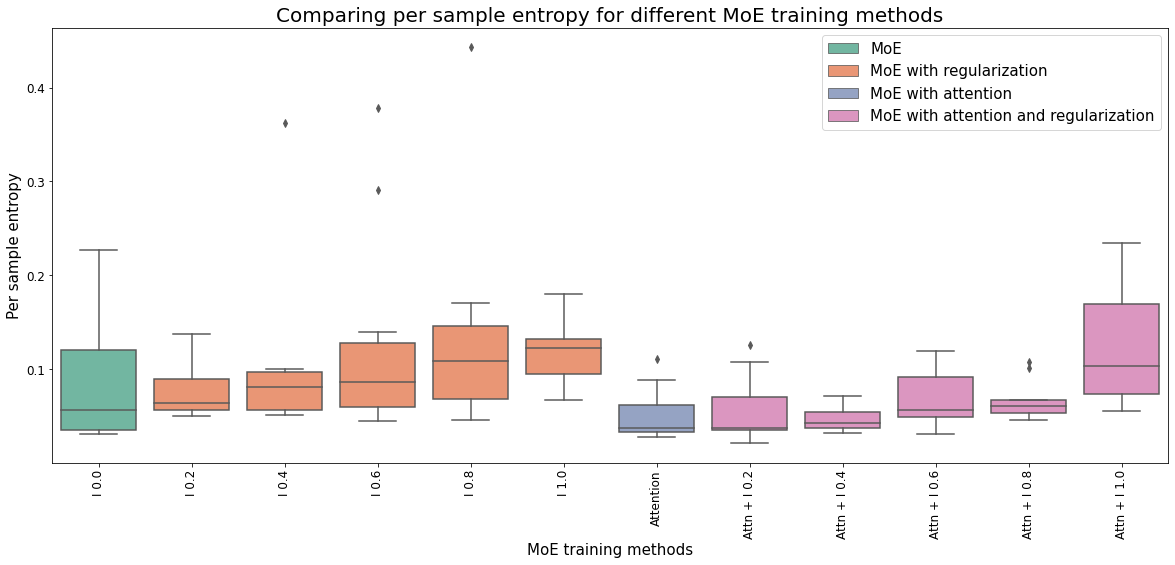

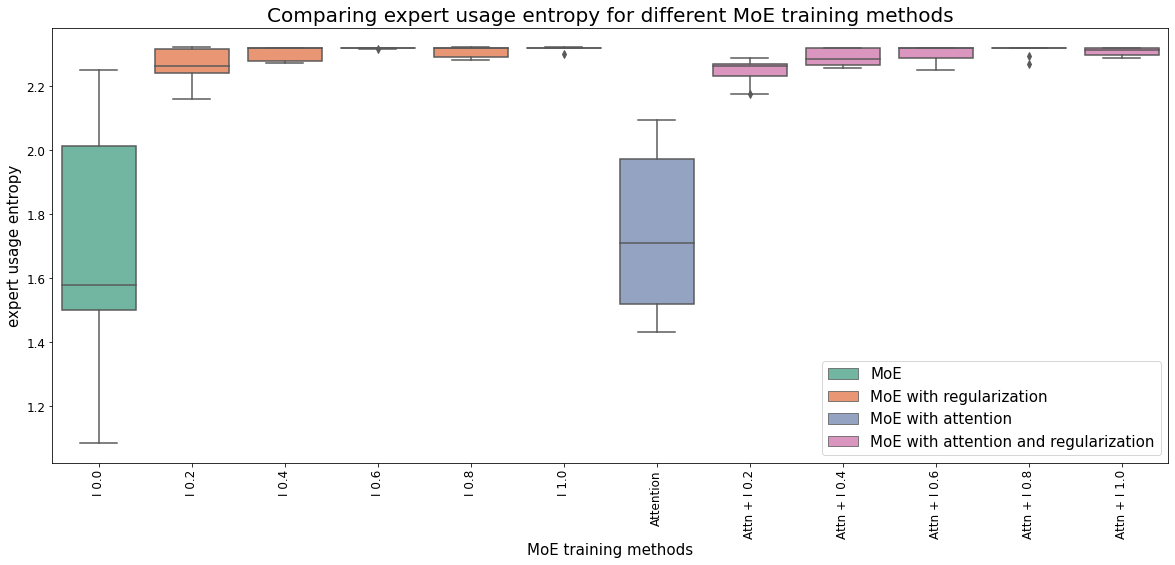

In [66]:
model_without_reg =  model_sample_sim_reg = 'mnist_transform_without_reg'
model_with_reg = 'mnist_transform_with_reg'
model_with_attention = 'mnist_with_attention'
model_with_attn_reg = 'mnist_with_attn_reg'
# model_dual_temp_with_attention = 'mnist_dual_temp_with_attention'
# model_with_temp = 'mnist_dual_temp'
# model_with_reg_temp = 'mnist_dual_temp_with_reg_test'
# mnist_attn_output_reg = 'mnist_attn_output_reg'

total_experts = 5
num_classes = 10

temps = [1.1,1.2]
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 21, 2), np.arange(25, 51, 5)))
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 7, 2)))
temps = np.arange(1.1,1.6,0.1)
print(temps)
w_importance_range = [i * 0.2 for i in range(1, 6)]
print(w_importance_range)

boxplot(
        model_with_reg=model_with_reg, model_without_reg=model_without_reg, 
        model_with_attention=model_with_attention,
        model_with_attn_reg=model_with_attn_reg, 
        temps=temps,w_importance_range=w_importance_range,
        total_experts=total_experts, num_classes=num_classes, classes=range(num_classes), 
        testloader=testloader, figname='mnist_attentive_gate')

In [79]:
model_single = 'mnist_single_model'
model_with_attention =  'mnist_with_attention'
model_with_temp = 'mnist_dual_temp'
model_with_reg_temp = 'mnist_dual_temp_with_regularization'
model_with_temp_decay = 'mnist_dual_temp_on_schedule'
model_with_reg = 'mnist_with_regularization'
model_without_reg = 'mnist_without_regularization'

total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps = [1.2, 2.0]
w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_single, model_with_attention, model_with_temp, model_with_temp_decay, model_with_reg, model_without_reg, model_with_reg_temp, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

FileNotFoundError: [Errno 2] No such file or directory: '../models/test/mnist_with_regularization_10_5_models.pt'

<Figure size 432x288 with 0 Axes>

In [ ]:
model_single = 'imbalanced_mnist_single_model'
model_with_temp = 'mnist_imbalanced_5_dual_temp'
model_with_temp_on_delay = 'mnist_imbalanced_5_dual_temp_on_schedule'
model_with_reg = 'mnist_imbalanced_5_with_regularization'
model_without_reg = 'mnist_imbalanced_5_without_regularization'
model_with_reg_temp = 'mnist_imbalanced_5_dual_temp_with_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps = [1.2, 2.0]
w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_single, model_with_temp, model_with_temp_on_delay, model_with_reg, model_without_reg, model_with_reg_temp, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_single = 'rot_mnist_single_model'
model_with_temp = 'rot_mnist_dual_temp'
model_with_reg = 'rot_mnist_with_regularization'
model_without_reg = 'rot_mnist_without_regularization'

total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(0.5,1.0,0.1), np.arange(1.1,1.6,0.1), np.arange(2,6) ))
w_importance_range = [i * 0.2 for i in range(1, 6)]

rot_unrot_mnist_classes = ['0','1','2','3','4','rotated 0', 'rotated 1', 'rotated 2', 'rotated 3', 'rotated 4']
boxplot(model_single, model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes,rot_unrot_mnist_classes , rot_unrot_testloader)

In [ ]:
model_single = 'fmnist_mnist_single_model'
model_with_temp = 'fmnist_mnist_dual_temp'
model_with_reg = 'fmnist_mnist_with_regularization'
model_without_reg = 'fmnist_mnist_without_regularization'
total_experts = 6
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]
boxplot(model_single, model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes_fmnist_mnist, classes_fmnist_mnist, fmnist_mnist_testloader)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
                 total_experts, num_classes, classes, testloader):
    
    num_epochs = 20

    min_values = []
    max_values = []
    mean_values = []
    std_values = []
    mutual_info = []
    models = []

    w_importance = 0.0

    for T in temps:    

        m = model_with_temp

        plot_file = generate_plot_file(m, w_importance,'temp_'+"{:.1f}".format(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

        print('Model:', plot_file)

        error_values = []
        for model in model_1:
            for e_key, e_val in model.items():
                history = model[e_key]['experts'][total_experts]['history']
                error = 1-np.asarray(history['accuracy'])
                error_values.append(error[-1])

        models.append(model_1[np.argmin(error_values)])

        min_values.append("{:.3f}".format(min(error_values)))
        max_values.append("{:.3f}".format(max(error_values)))
        mean_values.append("{:.3f}".format(mean(error_values)))
        std_values.append("{:.3f}".format(np.std(error_values)))
        mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    T = [ 'T '+"{:.1f}".format(t) for t in temps]
    N_T = len(T)

    for w_importance in w_importance_range:

        m = model_with_reg

        plot_file = generate_plot_file(m, w_importance, str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
        print('Model:', plot_file)

        error_values = []
        for model in model_2:
            for e_key, e_val in model.items():
                history = model[e_key]['experts'][total_experts]['history']
                error = 1-np.asarray(history['accuracy'])
                error_values.append(error[-1])

        models.append(model_2[np.argmin(error_values)])
#         models.append(model_2[-1])

        min_values.append("{:.3f}".format(min(error_values)))
        max_values.append("{:.3f}".format(max(error_values)))
        mean_values.append("{:.3f}".format(mean(error_values)))
        std_values.append("{:.3f}".format(np.std(error_values)))
        mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    N_I = len(w_importance_range)
    I = [ 'I '+"{:.1f}".format(i) for i in w_importance_range]

    m = model_without_reg

    plot_file = generate_plot_file(m, 0.0, str(num_classes)+'_'+str(total_experts)+'_models.pt')


    # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
    # model you build above
    model_3 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
    print('Model:', plot_file)

    error_values = []
    for model in model_3:
        history = model[e_key]['experts'][total_experts]['history']
        for e_key, e_val in model.items():
            error = 1-np.asarray(history['accuracy'])
            error_values.append(error[-1])

    models.append(model_3[np.argmin(error_values)])
#     models.append(model_3[-1])
    
    min_values.append("{:.3f}".format(min(error_values)))
    max_values.append("{:.3f}".format(max(error_values)))
    mean_values.append("{:.3f}".format(mean(error_values)))
    std_values.append("{:.3f}".format(np.std(error_values)))
    mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    method = T + I + ['I 0.0']
    N = N_T + N_I + 1

    print('N',N)
    data = np.hstack((np.asarray(method).reshape(N,1), np.asarray(min_values).reshape(N,1), np.asarray(max_values).reshape(N,1), 
                      np.asarray(mean_values).reshape(N,1), np.asarray(std_values).reshape(N,1), 
                      np.asarray(mutual_info).reshape(N,1)))

    print(data.shape)

    columns = ['Method', 'Min', 'Max', 'Mean', 'Std', 'Mutual Info']
    colors = np.array([['w']*len(columns)]*N)
    colors[np.argmin(data[:,1]), 1] = 'y'
    colors[np.argmax(data[:,2]), 2] = 'y'
    colors[np.argmin(data[:,3]), 3] = 'y'
    colors[np.argmin(data[:,4]), 4] = 'y'
    colors[np.argmax(data[:,5]), 5] = 'y'

    fig, ax = plt.subplots()
    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    ax.table(cellText=data, colLabels=columns, cellColours=colors, loc='center')

    fig.tight_layout()

    plt.show()


    model = models[np.argmin(data[0:N_T,1])]

    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model with reg
    for e_key, e_val in model.items():


        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()


    model = models[N_T+np.argmin(data[N_T:N-1,1])]
    
    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model without reg
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()

    model = models[-1]

    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model without reg
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()

    # plot error rates
    fig2,ax2 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16,4))
    ax2 = ax2.flatten()

    fig3,ax3 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

    fig4,ax4 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))
    
    fig5,ax5 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

    for i, model in enumerate(models):
        for e_key, e_val in model.items():

            # plot training and validation error rates
            sns.lineplot(x=range(num_epochs), y=1-np.asarray(model[e_key]['experts'][total_experts]['history']['accuracy']), ax=ax2[0])
            sns.lineplot(x=range(num_epochs), y=1-np.asarray(model[e_key]['experts'][total_experts]['history']['val_accuracy']), ax=ax2[1])

            # plot training loss
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['loss']), ax=ax3)

            # plot mutual information
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['mutual_EY']), ax=ax4)

            # plot mutual information
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['H_EY']), ax=ax5)

    legend = data[:,0]

    ax2[0].legend(legend)

    ax2[0].set_xlabel('epochs')
    ax2[0].set_xticks(range(num_epochs+1))
    ax2[0].set_ylabel('train error rate')
    ax2[0].set_ylim(ymin=0)


    ax2[1].legend(legend)

    ax2[1].set_xlabel('epochs')
    ax2[1].set_xticks(range(num_epochs+1))
    ax2[1].set_ylabel('validation error rate')
    ax2[1].set_ylim(ymin=0)


    ax3.legend(legend)

    ax3.set_xlabel('epochs')
    ax3.set_xticks(range(num_epochs+1))
    ax3.set_ylabel('training loss')
    ax3.set_ylim(ymin=0)

    ax4.legend(legend)

    ax4.set_xlabel('epochs')
    ax4.set_xticks(range(num_epochs+1))
    ax4.set_ylabel('mutual information')
    ax4.set_ylim(ymin=0)
    
    ax5.legend(legend)

    ax5.set_xlabel('epochs')
    ax5.set_xticks(range(num_epochs+1))
    ax5.set_ylabel('Entropy EY')
    ax5.set_ylim(ymin=0)

    plt.show()


### Results for MNIST data

In [ ]:
model_with_temp = 'mnist_dual_temp'
model_with_reg = 'mnist_with_regularization'
model_without_reg = 'mnist_without_regularization'
total_experts = 5
num_classes = 10
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_with_temp = 'mnist_imbalanced_5_dual_temp'
model_with_reg = 'mnist_imbalanced_5_with_regularization'
model_without_reg = 'mnist_imbalanced_5_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_with_temp = 'rot_mnist_dual_temp'
model_with_reg = 'rot_mnist_with_regularization'
model_without_reg = 'rot_mnist_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

rot_unrot_mnist_classes = ['0','1','2','3','4','rotated 0', 'rotated 1', 'rotated 2', 'rotated 3', 'rotated 4']
plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
             total_experts, num_classes,rot_unrot_mnist_classes , rot_unrot_testloader)

### Results for combined FMNIST and MNIST data

In [ ]:
model_with_temp = 'fmnist_mnist_dual_temp'
model_with_reg = 'fmnist_mnist_with_regularization'
model_without_reg = 'fmnist_mnist_without_regularization'
total_experts = 6

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
             total_experts, num_classes_fmnist_mnist, classes_fmnist_mnist, fmnist_mnist_testloader)

In [ ]:
def plot_gate_prob(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
                 total_experts, num_classes, classes, testloader):
    
    w_importance = 0.0
    
    for T in temps:    

        m = model_with_temp

        plot_file = generate_plot_file(m, w_importance,'temp_'+"{:.1f}".format(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)[5]
        
        for e_key, e_val in model.items():
            history = model[e_key]['experts'][total_experts]['history']
            mean_gate_probability = np.asarray(history['mean_gate_probability'])
            var_gate_probability = np.asarray(history['var_gate_probability'])
            print('Temperature ', "{:.1f}".format(T))
            print(mean_gate_probability.shape)
            plt.imshow(np.transpose(mean_gate_probability))
            plt.show()
            plt.imshow(np.transpose(var_gate_probability))
            plt.show()
        
    

#     for w_importance in w_importance_range:

#         m = model_with_reg

#         plot_file = generate_plot_file(m, w_importance, str(num_classes)+'_'+str(total_experts)+'_models.pt')


#         # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
#         # model you build above
#         model_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
# #         print('Model:', plot_file)

#         error_values = []
#         for model in model_2:
#             for e_key, e_val in model.items():
#                 history = model[e_key]['experts'][total_experts]['history']
#                 error = 1-np.asarray(history['accuracy'])
#                 val_error = 1-np.asarray(history['val_accuracy'])
#                 y_error.append(error[-1])
#                 y_val_error.append(val_error[-1])
#                 y_mi.append(history['mutual_EY'][-1])
#                 y_H_EY.append(history['H_EY'][-1])
#                 y_sample_H.append(history['sample_entropy'][-1])
#                 x.append('I '+"{:.1f}".format(w_importance))


In [ ]:
model_with_temp = 'fmnist_mnist_dual_temp'
model_with_reg = 'fmnist_mnist_with_regularization'
model_without_reg = 'fmnist_mnist_without_regularization'
total_experts = 6
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]
plot_gate_prob(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes_fmnist_mnist, classes_fmnist_mnist, fmnist_mnist_testloader)

## Experiment 1: Train MoE expectation model with importance

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_on_validation'

In [ ]:
num_epochs = 20

In [ ]:
# Set train and test size
trainsize = 2048
testsize = 2000
valsize = 10048

In [ ]:
# Load and split data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=transform)

batch_size = 64
# dataloaders
trainloaders = []
for i in range(total_experts):
    dataset = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(i*trainsize,(i*trainsize)+trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)
    trainloaders.append(dataset)
    all_labels = []
    for inputs, labels in dataset:
        all_labels.append(labels)
    all_labels = torch.stack(all_labels)
i+=1
valloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(i*trainsize,(i*trainsize)+valsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(0, valsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(0,testsize)),
                                         batch_size=testsize,
                                         shuffle=False)
num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))
print(len(trainloaders))

In [ ]:
def train_experts(expert_models, trainloaders, accuracy, num_epochs):
    for i, expert in enumerate(expert_models):
        print('Training Expert ', i)
        optimizer_expert = optim.RMSprop(expert.parameters(),
                                      lr=0.001, momentum=0.9)

        loss_criterion = cross_entropy_loss()
        for epoch in range(num_epochs):
            running_loss = 0.0
            train_running_accuracy = 0.0
            num_batches = 0
            for inputs, labels in trainloaders[i]:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = expert(inputs)

                optimizer_expert.zero_grad()
                loss = loss_criterion(outputs, labels)

                loss.backward()

                optimizer_expert.step()

                running_loss += loss.item()

                outputs = expert(inputs)

                acc = accuracy(outputs, labels)
                train_running_accuracy += acc

                num_batches += 1

            print('epoch %d' % epoch,
                  'training loss %.2f' % (running_loss/num_batches),
                   ', training accuracy %.2f' % (train_running_accuracy/num_batches),
                   )

In [ ]:
# Train models model_1

n_run_models = []
cv = []
accuracies = []
for e_epoch in range(1,6):
    for g_epoch in range(1,2):
        models = {
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
            }

        # Build model with un-trained experts
        for key, val in models.items():
            print('Model:', key, total_experts, 'Experts')
            print('Building model with un-trained experts')
            # copy and save the expert models to save the parameters

            expert_models = experts(total_experts, [None]*total_experts, num_classes, 
                                             [num_classes]*total_experts).to(device)

            gate_model = gate_layers(total_experts, num_classes).to(device)

            optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                          lr=0.001, momentum=0.9)
            for epoch in range(1):
                print('\nTraining Experts')
                train_experts(expert_models, trainloaders, accuracy, e_epoch)


                moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                                         experts=expert_models, gate=gate_model)


                print('\nTraining Gate')
                hist = moe_model.train_on_validation(valloader, testloader,  val['loss'], 
                                                     optimizer_gate=optimizer_gate, 
                                                     accuracy=accuracy, epochs=g_epoch)
            moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                                         experts=expert_models, gate=gate_model)
            
            optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                      lr=0.001, momentum=0.9)
            print('\nTraining MoE Model')
            hist = moe_model.train(trainloader, testloader,  val['loss'], 
                                                 optimizer_moe=optimizer_moe, 
                                                 accuracy=accuracy, epochs=num_epochs)
                
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = moe_model(inputs)
                gate_outputs = moe_model.gate_outputs
                gd = torch.sum(gate_outputs, dim=0)
                cv.append((torch.std(gd)/torch.mean(gd)).item())
                accuracies.append(accuracy(outputs, labels).item())
            print(cv[-1], accuracies[-1])
            
            val['experts'][total_experts] = {'model':moe_model, 'history':hist}
        n_run_models.append(models)
        

# Save all the trained models
plot_file = generate_plot_file(model_1, str(num_classes)+'_'+str(total_experts)+'_models.pt')
print(plot_file)
torch.save(n_run_models, open(os.path.join(model_path, plot_file),'wb'))

In [ ]:
torch.save([cv,accuracies], open('results_cv_accuracies.pt','wb'))

In [ ]:
cv, accuracies = torch.load(open('results_cv_accuracies.pt','rb'))

In [ ]:
cv = np.transpose(np.around(cv, decimals=3))
accuracies = np.transpose(np.around(accuracies, decimals=2))
cv

In [ ]:
epochs = []
for i in range(1,6):
    for j in range(1,2):
        epochs.append([[i],[j]])
epochs = np.transpose(np.hstack(epochs))
values = np.transpose(np.vstack((cv,accuracies)))
from numpy.lib import recfunctions as rfn
data = np.hstack((epochs,values))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

m = model_1
total_experts = 5
plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_models.pt')
models_list = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
print(plot_file)

# columns = ('Expert Epoch', 'Expert Gate', 'CV', 'Accuracy')
# # Add a table at the bottom of the axes
# plt.box(on=None)
# ax = plt.gca()
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# the_table = plt.table(cellText=data,
#                       colLabels=columns,
#                      loc='center')
# image_file = generate_plot_file(m, 'cv_accuracy_table_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
# print(image_file)
# plt.savefig(os.path.join(fig_path, image_file))
# plt.show()

# fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
# sns.lineplot(x=cv,y=accuracies, ax=ax)
# plt.show()
                      
for i, models in enumerate(models_list):
    # Plotting for the model of the first run
    print('\nE epoch:', data[i,0], 'G epoch:',data[i,1])
    for e_key, e_val in models.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        for images, labels in testloader:
            fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
            images, labels = images.to(device), labels.to(device)
            moe_model = e_val['experts'][total_experts]['model']

            # predict the classes for test data
            pred = moe_model(images)
            pred_labels = torch.argmax(pred, dim=1)

            expert_outputs = moe_model.expert_outputs
            gate_outputs = moe_model.gate_outputs

            # plot the confusion matrix
            print('\nConfusion matrix of predictions of the MNIST test data by MoE expectation model')
            sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1, cmap=cmap, fmt='d')
            image_file = generate_plot_file(m, 'conf_mat_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig1.savefig(os.path.join(fig_path, image_file))
            plt.show()

            fig2,ax2 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

            # get the experts selected by the gate for each sample
            pred_gate_labels = torch.argmax(gate_outputs, dim=1)

            # plot the expert selection table
            print('\nExperts used by the gate for classification of each digit')
            class_expert_table = np.asarray([[0] * num_classes]*total_experts)
            for label, expert in zip(labels, pred_gate_labels):
                class_expert_table[expert,label] += 1
            sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d', ax=ax2)

            image_file = generate_plot_file(m, 'class_expert_table_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig2.savefig(os.path.join(fig_path, image_file))
            plt.show()

In [ ]:
new_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(valsize, 3*valsize)), 
                                          batch_size=2*valsize,
                                          shuffle=True)

In [ ]:
image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))
print(len(new_trainloader.dataset))

In [ ]:
indices = None
for inputs, labels in new_trainloader:
    inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
    outputs = sm(inputs)
    indices = torch.where((torch.argmax(outputs, dim=1)==labels)==True)[0]

In [ ]:
new_trainloader_1 = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, (indices+valsize)[0:valsize]), 
                                          batch_size=batch_size,
                                          shuffle=True)
print(len(new_trainloader.dataset))

In [ ]:
model_3 = 'selected_data'

In [ ]:
# Train models model_1, model_2 and model_3 for 10 runs
models = {
    'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
    }

# Build model with un-trained experts
for key, val in models.items():
    print('Model:', key, total_experts, 'Experts')
    # copy and save the expert models to save the parameters
    expert_models = experts(total_experts, [None]*total_experts, num_classes, 
                                 [num_classes]*total_experts).to(device)

    gate_model = gate_layers(total_experts, num_classes).to(device)

    moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                             experts=expert_models, gate=gate_model)


    optimizer_moe = optim.RMSprop(moe_model.parameters(),
                              lr=0.001, momentum=0.9)
    hist = moe_model.train(new_trainloader_1, testloader,  val['loss'], optimizer_moe, 
                           w_importance=1.0,
                           accuracy=accuracy, epochs=num_epochs)
    val['experts'][total_experts] = {'model':moe_model, 'history':hist}

# Save all the trained models
plot_file = generate_plot_file(model_3, 'importance_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')
print(plot_file)
torch.save(models,open(os.path.join(model_path, plot_file),'wb'))

In [ ]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

m = model_3
total_experts = 5
plot_file = generate_plot_file(model_3, 'importance_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')
models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
                      
# Plotting for the model of the first run
for e_key, e_val in models.items():
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

    for images, labels in testloader:
        fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
        images, labels = images.to(device), labels.to(device)
        moe_model = e_val['experts'][total_experts]['model']

        # predict the classes for test data
        pred = moe_model(images)
        pred_labels = torch.argmax(pred, dim=1)
        expert_outputs = moe_model.expert_outputs
        gate_outputs = moe_model.gate_outputs

        # plot the confusion matrix
        print('\nConfusion matrix of predictions of the MNIST test data by MoE expectation model')
        sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1, cmap=cmap, fmt='d')
        image_file = generate_plot_file(m, 'conf_mat_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        fig1.savefig(os.path.join(fig_path, image_file))
        plt.show()

        fig2,ax2 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

        # get the experts selected by the gate for each sample
        pred_gate_labels = torch.argmax(gate_outputs, dim=1)

        # plot the expert selection table
        print('\nExperts used by the gate for classification of each digit')
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(labels, pred_gate_labels):
            class_expert_table[expert,label] += 1
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d', ax=ax2)

        image_file = generate_plot_file(m, 'class_expert_table_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        fig2.savefig(os.path.join(fig_path, image_file))
        plt.show()
        
        misclassified = torch.where((pred_labels == labels)==False)[0]
        for i in range(num_classes):
            indices = labels[misclassified]==i
            print(i,' is misclassified as ', pred_labels[misclassified][indices])
            images_orig = images[misclassified][indices]
            img_grid = torchvision.utils.make_grid(images_orig)
            # show images
            imshow(img_grid, one_channel=True)
